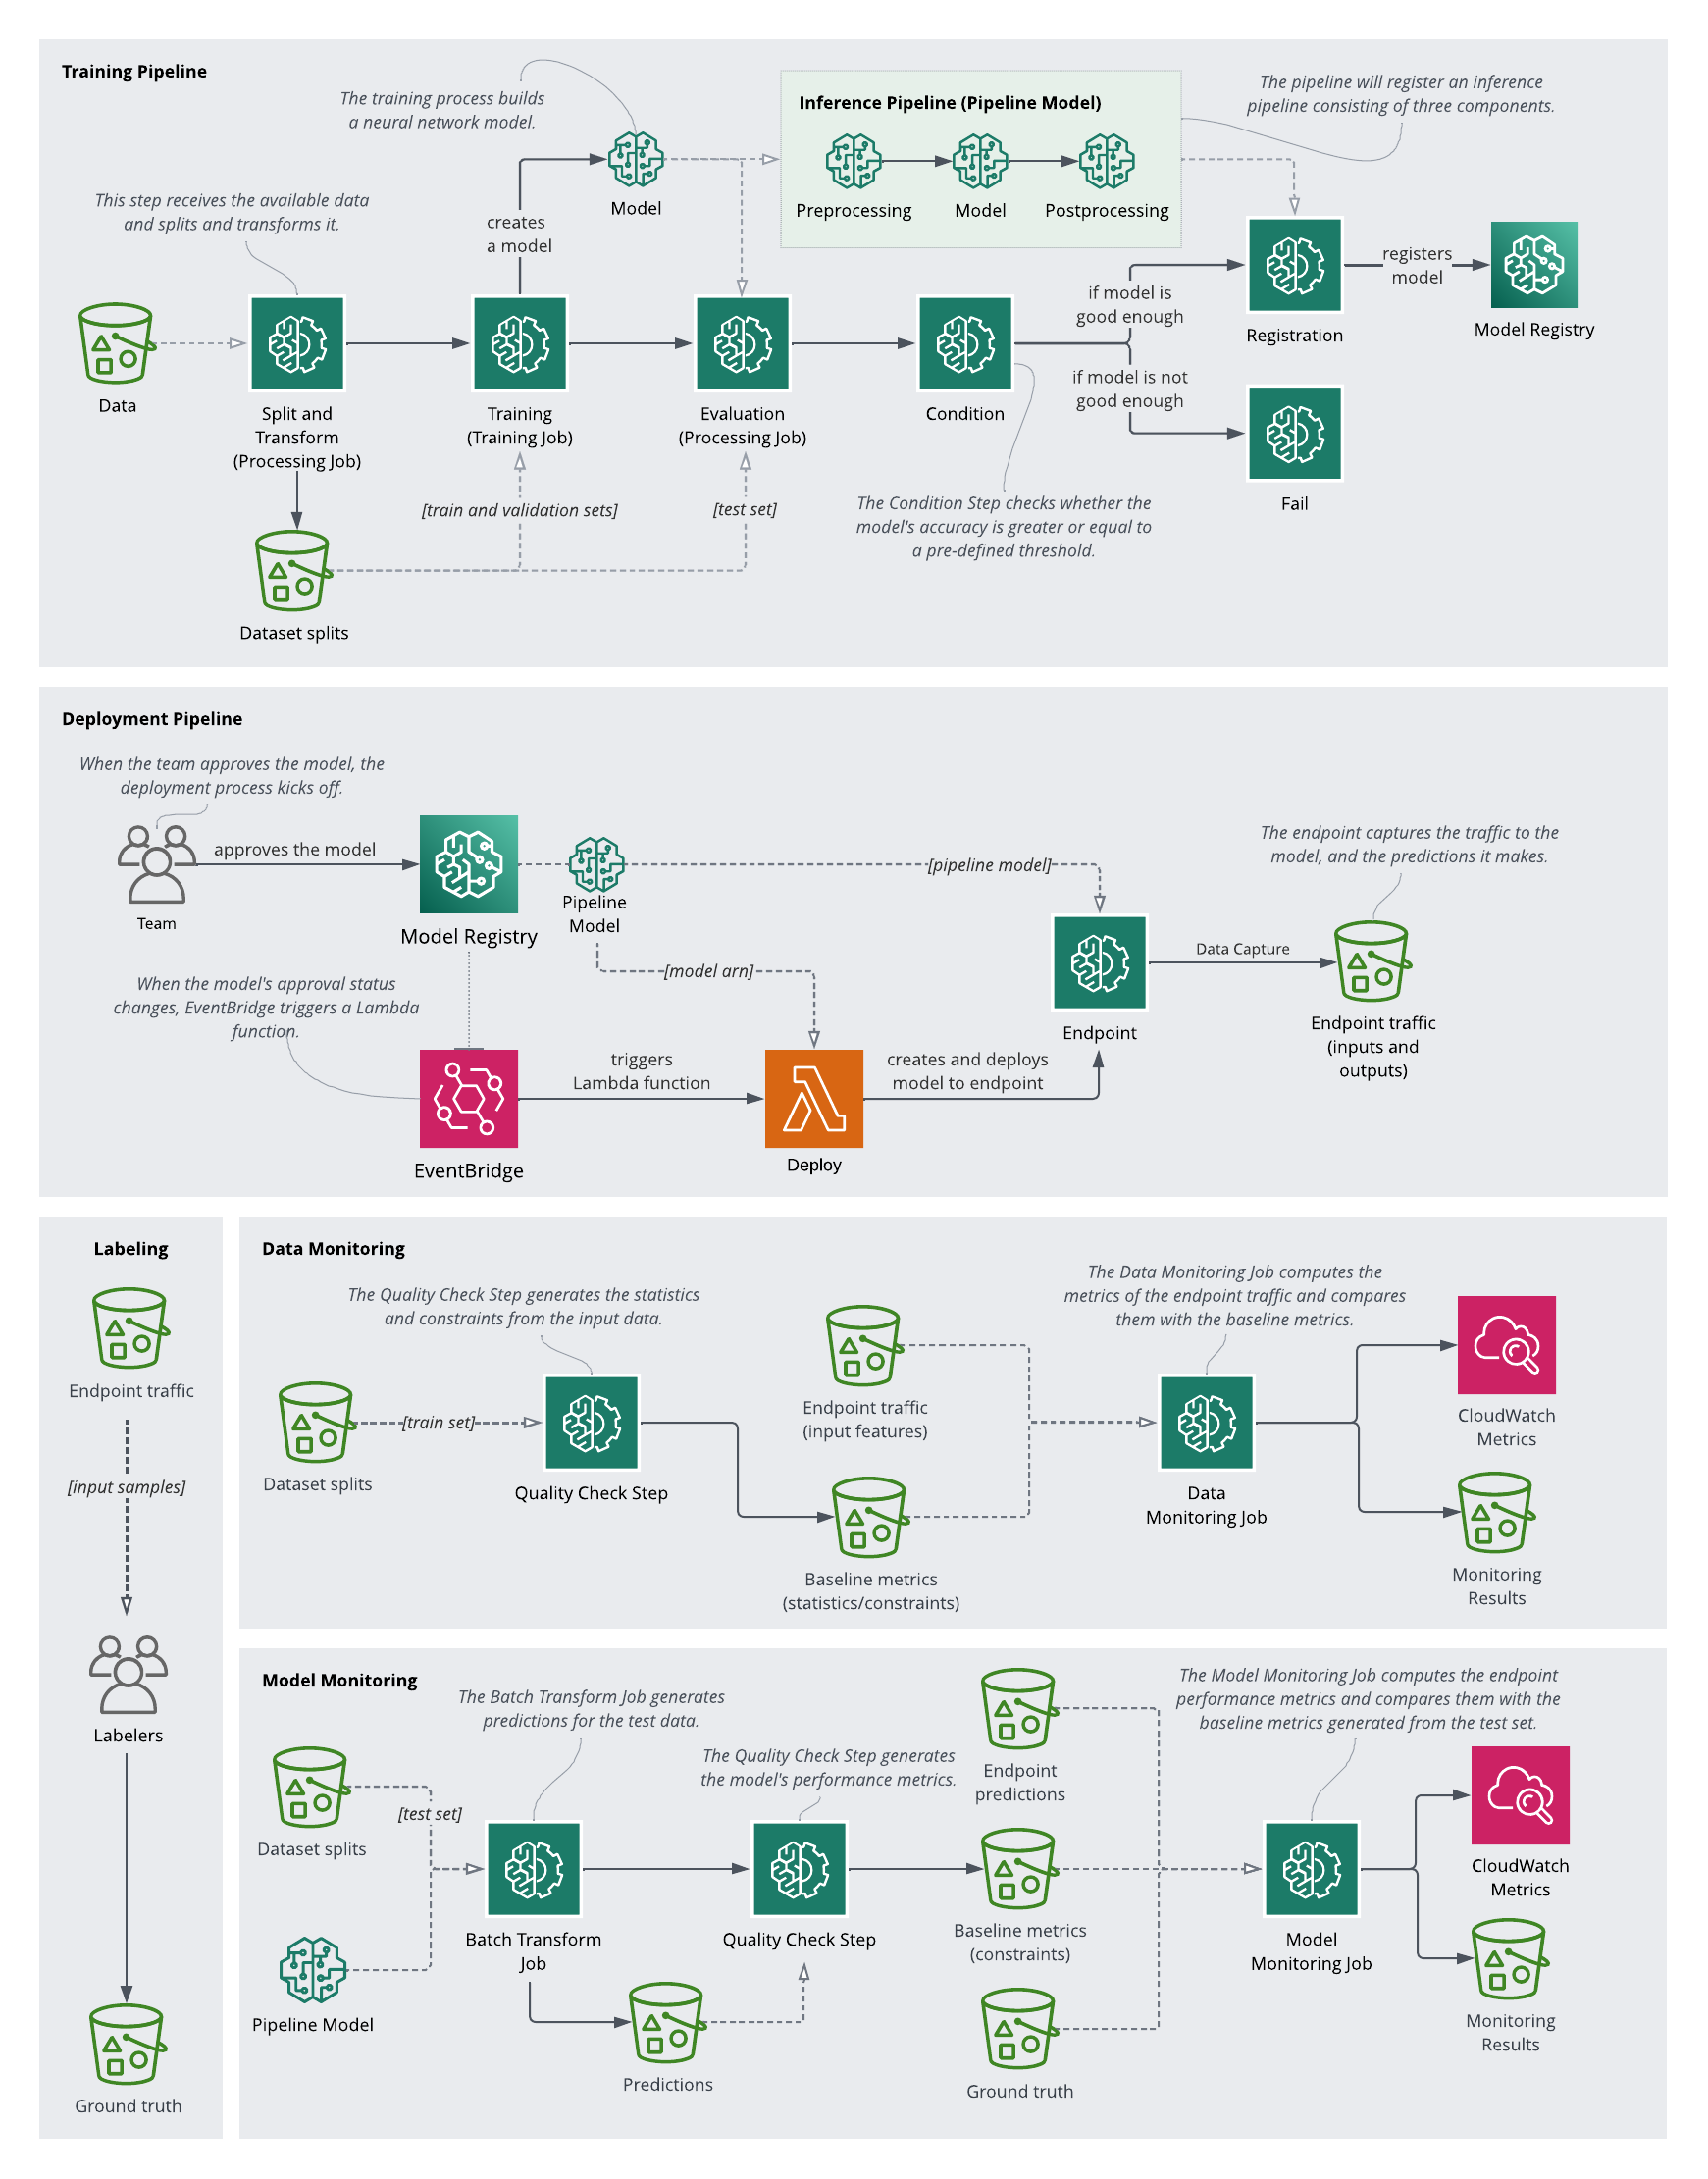

 The Architecture basically consists of 4 pipeline -  A training pipeline, an inference pipeline, a deployment pipeline, and a monitoring pipeline.

Above is an architectural diagram showing how the system is structured:

Lets set up the environment and prepare to run the notebook.

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import os
import json
import logging
import sys
from pathlib import Path

import ipytest

CODE_FOLDER = Path("code")

if not os.path.exists(CODE_FOLDER):
    os.makedirs(CODE_FOLDER)
    
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

We can run this notebook in Local Mode to test some of the system components in local environment. Unfortunately, not every component is supported in Local Mode.

Setting the LOCAL_MODE variable to True will run every supported pipeline component locally. Setting the variable to False will run the pipeline in SageMaker.

In [3]:
LOCAL_MODE = True

Loading the environment variables we need to run the notebook.

In [4]:
import os

bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

In [5]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command.
architecture = !(uname -m)

IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"

Let's create a configuration dictionary with different settings depending on whether we are running the pipeline in Local Mode. We'll use this dictionary to configure the pipeline components.

In [6]:
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession

pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": (
            "sagemaker-tensorflow-toolkit-local" if IS_ARM64_ARCHITECTURE else None
        ),
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

# These specific settings refer to the SageMaker
# TensorFlow container we'll use.
config["framework_version"] = "2.12"
config["py_version"] = "py310"

Windows Support for Local Mode is Experimental


In [7]:
import boto3

S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

IAM - https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/iam.html

sagemaker - https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html

# Exploratory Data Analysis

In [8]:
import numpy as np
import pandas as pd

penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


We can see the dataset contains the following columns:

species: The species of a penguin. This is the column we want to predict.

island: The island where the penguin was found

culmen_length_mm: The length of the penguin's culmen (bill) in millimeters

culmen_depth_mm: The depth of the penguin's culmen in millimeters

flipper_length_mm: The length of the penguin's flipper in millimeters

body_mass_g: The body mass of the penguin in grams

sex: The sex of the penguin

In [9]:
penguins.describe(include="all")

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


In [10]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution, end="\n\n")
print(island_distribution, end="\n\n")
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


The distribution of the categories in our data are:

1. species: There are 3 species of penguins in the dataset: Adelie (152), Gentoo (124), and Chinstrap (68).
2. island: Penguins are from 3 islands: Biscoe (168), Dream (124), and Torgersen (52).
3. sex: We have 168 male penguins, 165 female penguins, and 1 penguin with an ambiguous gender (.).

Let's replace the ambiguous value in the sex column with a null value:

In [11]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)

# Let's display the new distribution of the column:
sex_distribution = penguins["sex"].value_counts()
sex_distribution

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

In [12]:
penguins.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let get rid of the missing values.

In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)

# Let's display again the number of missing values:
penguins.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

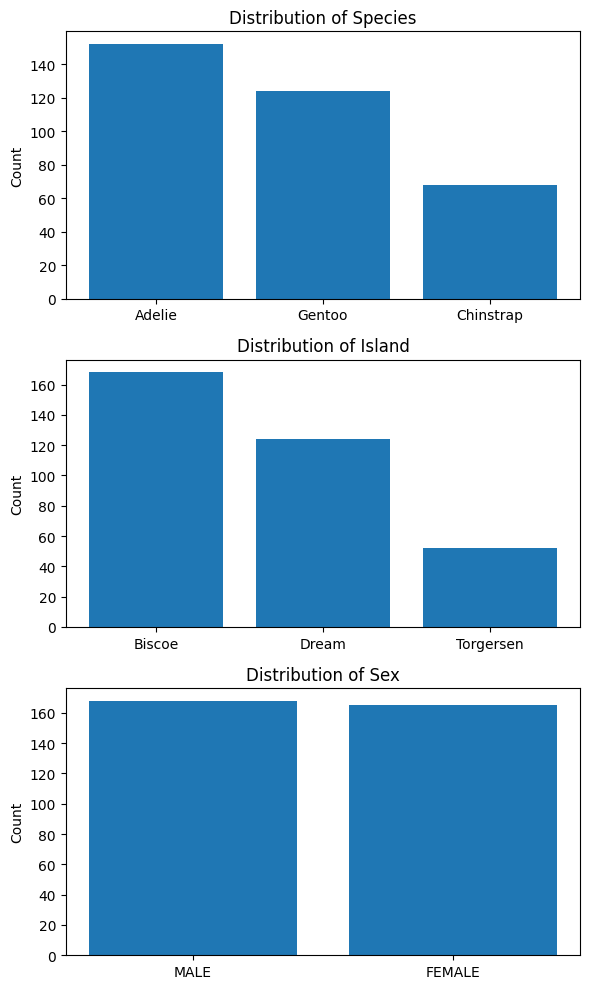

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

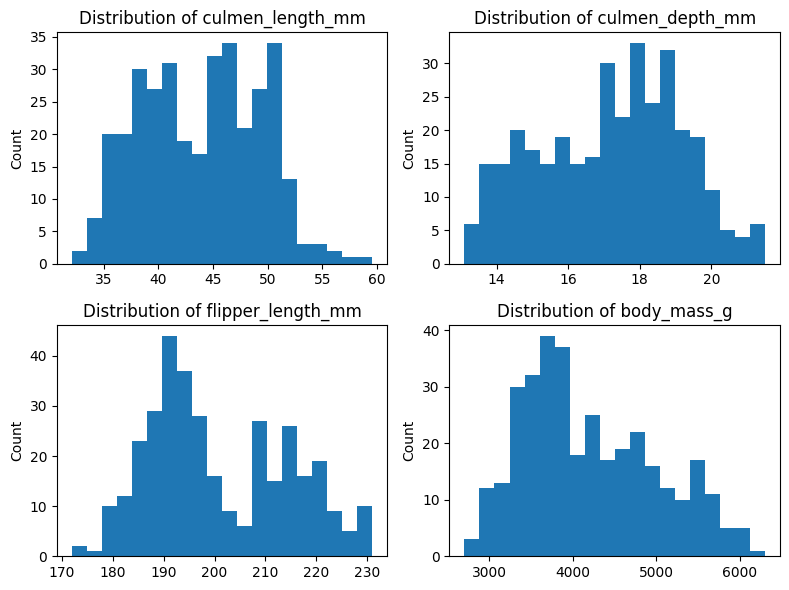

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of body_mass_g")

plt.tight_layout()
plt.show()

In [16]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


Here are three examples of what we get from interpreting the covariance matrix below:

1. The positive covariance of 50.26 between culmen length and flippler length suggests that larger values of culmen length are associated with larger values of flipper length. As one increases, generally so does the other.
2. The positive covariance of 2596.97 between culmen length and body mass suggests that heavier penguins generally have longer culmens. There is a tendency for these two variables to increase together.
3. The negative covariance of -742.66 between culmen depth and body mass suggests a general tendency that penguins with deeper culmens weigh less.

Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables:

In [17]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have longer flippers.
2. Penguins with a shallower culmen tend to have longer flippers.
3. Penguins with longer culmens tend to have longer flippers.

Let's display the distribution of species by island:

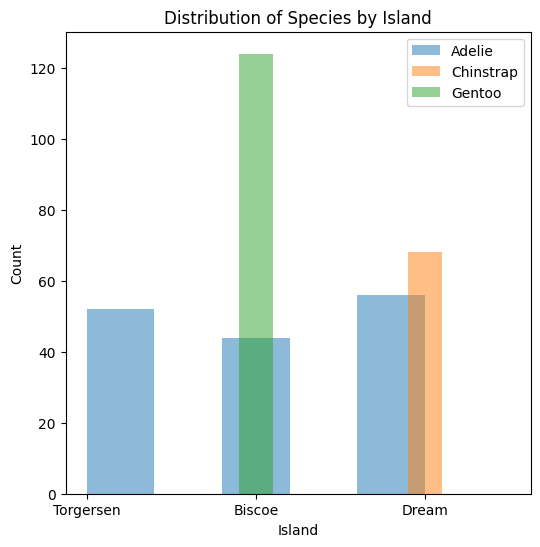

In [18]:
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], bins=5, alpha=0.5, label=species)

ax.set_xlabel("Island")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Island")
ax.legend()
plt.show()


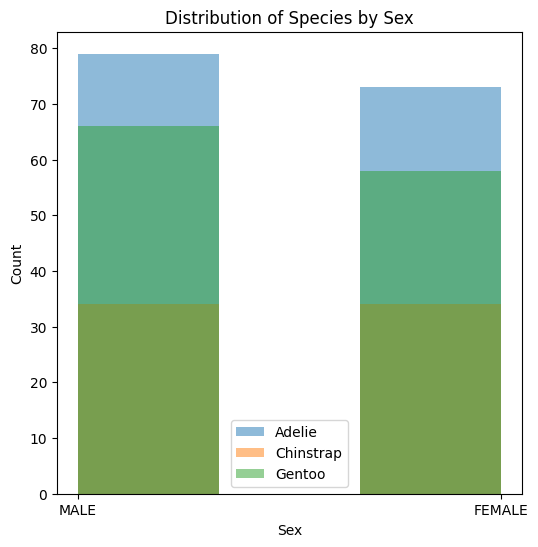

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))

for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["sex"], bins=3, alpha=0.5, label=species)

ax.set_xlabel("Sex")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Sex")

ax.legend()
plt.show()

# Splitting and Transforming the Data

The first step we need in the pipeline is a Processing Step to run a script that will split and transform the data.

This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data validation, and model evaluation. Check the ProcessingStep SageMaker's SDK documentation for more information.

We will store the script in a folder called processing and add it to the system path so we can later import it as a module.

Important Links - 

Processing step - https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep

 ProcessingStep SageMaker's SDK documentation - https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing

In [20]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/processing"])

In [21]:
%%writefile {CODE_FOLDER}/processing/script.py
# | filename: script.py
# | code-line-numbers: true

import os
import tarfile
import tempfile
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


def preprocess(base_directory):
    """Load the supplied data, split it and transform it."""
    df = _read_data_from_input_csv_files(base_directory)

    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])],
    )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(),
    )

    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_exclude="object"),
            ),
            ("categorical", categorical_transformer, ["island"]),
        ],
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_train_baseline(base_directory, df_train)
    _save_test_baseline(base_directory, df_test)

    y_train = target_transformer.fit_transform(
        np.array(df_train.species.values).reshape(-1, 1),
    )
    y_validation = target_transformer.transform(
        np.array(df_validation.species.values).reshape(-1, 1),
    )
    y_test = target_transformer.transform(
        np.array(df_test.species.values).reshape(-1, 1),
    )

    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)  # noqa: N806
    X_validation = features_transformer.transform(df_validation)  # noqa: N806
    X_test = features_transformer.transform(df_test)  # noqa: N806

    _save_splits(
        base_directory,
        X_train,
        y_train,
        X_validation,
        y_validation,
        X_test,
        y_test,
    )
    _save_model(base_directory, target_transformer, features_transformer)


def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files.

    This function reads every CSV file available and
    concatenates them into a single dataframe.
    """
    input_directory = Path(base_directory) / "input"
    files = list(input_directory.glob("*.csv"))

    if len(files) == 0:
        message = f"The are no CSV files in {input_directory.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)

    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """Split the data into train, validation, and test."""
    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_train_baseline(base_directory, df_train):
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline to
    determine the quality of the data that the model receives
    when deployed.
    """
    baseline_path = Path(base_directory) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    # To compute the data quality baseline, we don't need the
    # target variable, so we'll drop it from the dataframe.
    df = df.drop("species", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_directory, df_test):
    """Save the untransformed test data to disk.

    We will need the test data to compute a baseline to
    determine the quality of the model predictions when deployed.
    """
    baseline_path = Path(base_directory) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    # We'll use the test baseline to generate predictions later,
    # and we can't have a header line because the model won't be
    # able to make a prediction for it.
    df.to_csv(baseline_path / "test-baseline.csv", header=False, index=False)


def _save_splits(
    base_directory,
    X_train,  # noqa: N803
    y_train,
    X_validation,  # noqa: N803
    y_validation,
    X_test,  # noqa: N803
    y_test,
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.
    """
    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv",
        header=False,
        index=False,
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.

    This function creates a model.tar.gz file that
    contains the two transformation pipelines we built
    to transform the data.
    """
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")

        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(
                Path(directory) / "features.joblib", arcname="features.joblib",
            )


if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting code/processing/script.py


# Step 2 - Caching Configuration

Several SageMaker Pipeline steps support caching. When a step runs, and dependending on the configured caching policy, SageMaker will try to reuse the result of a previous successful run of the same step. You can find more information about this topic in Caching Pipeline Steps.

Link to caching document - https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html

Let's define a caching policy that we'll reuse on every step:

In [22]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

# Step 3 - Pipeline Configuration

We can parameterize a SageMaker Pipeline to make it more flexible. In this case, we'll use a parameter to pass the location of the dataset we want to process. We can execute the pipeline with different datasets by changing the value of this parameter. Check Pipeline Parameters for more information.


Link - https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html

In [23]:
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

# Step 4 - Setting up the Processing Step

Let's now define the ProcessingStep that we'll use in the pipeline to run the script that will split and transform the data.

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch a Processing Job. To run the script we created, we need access to Scikit-Learn, so we can use the SKLearnProcessor processor that comes out-of-the-box with the SageMaker's Python SDK.

SageMaker manages the infrastructure of a Processing Job. It provisions resources for the duration of the job, and cleans up when it completes. The Processing Container image that SageMaker uses to run a Processing Job can either be a SageMaker built-in image or a custom image:

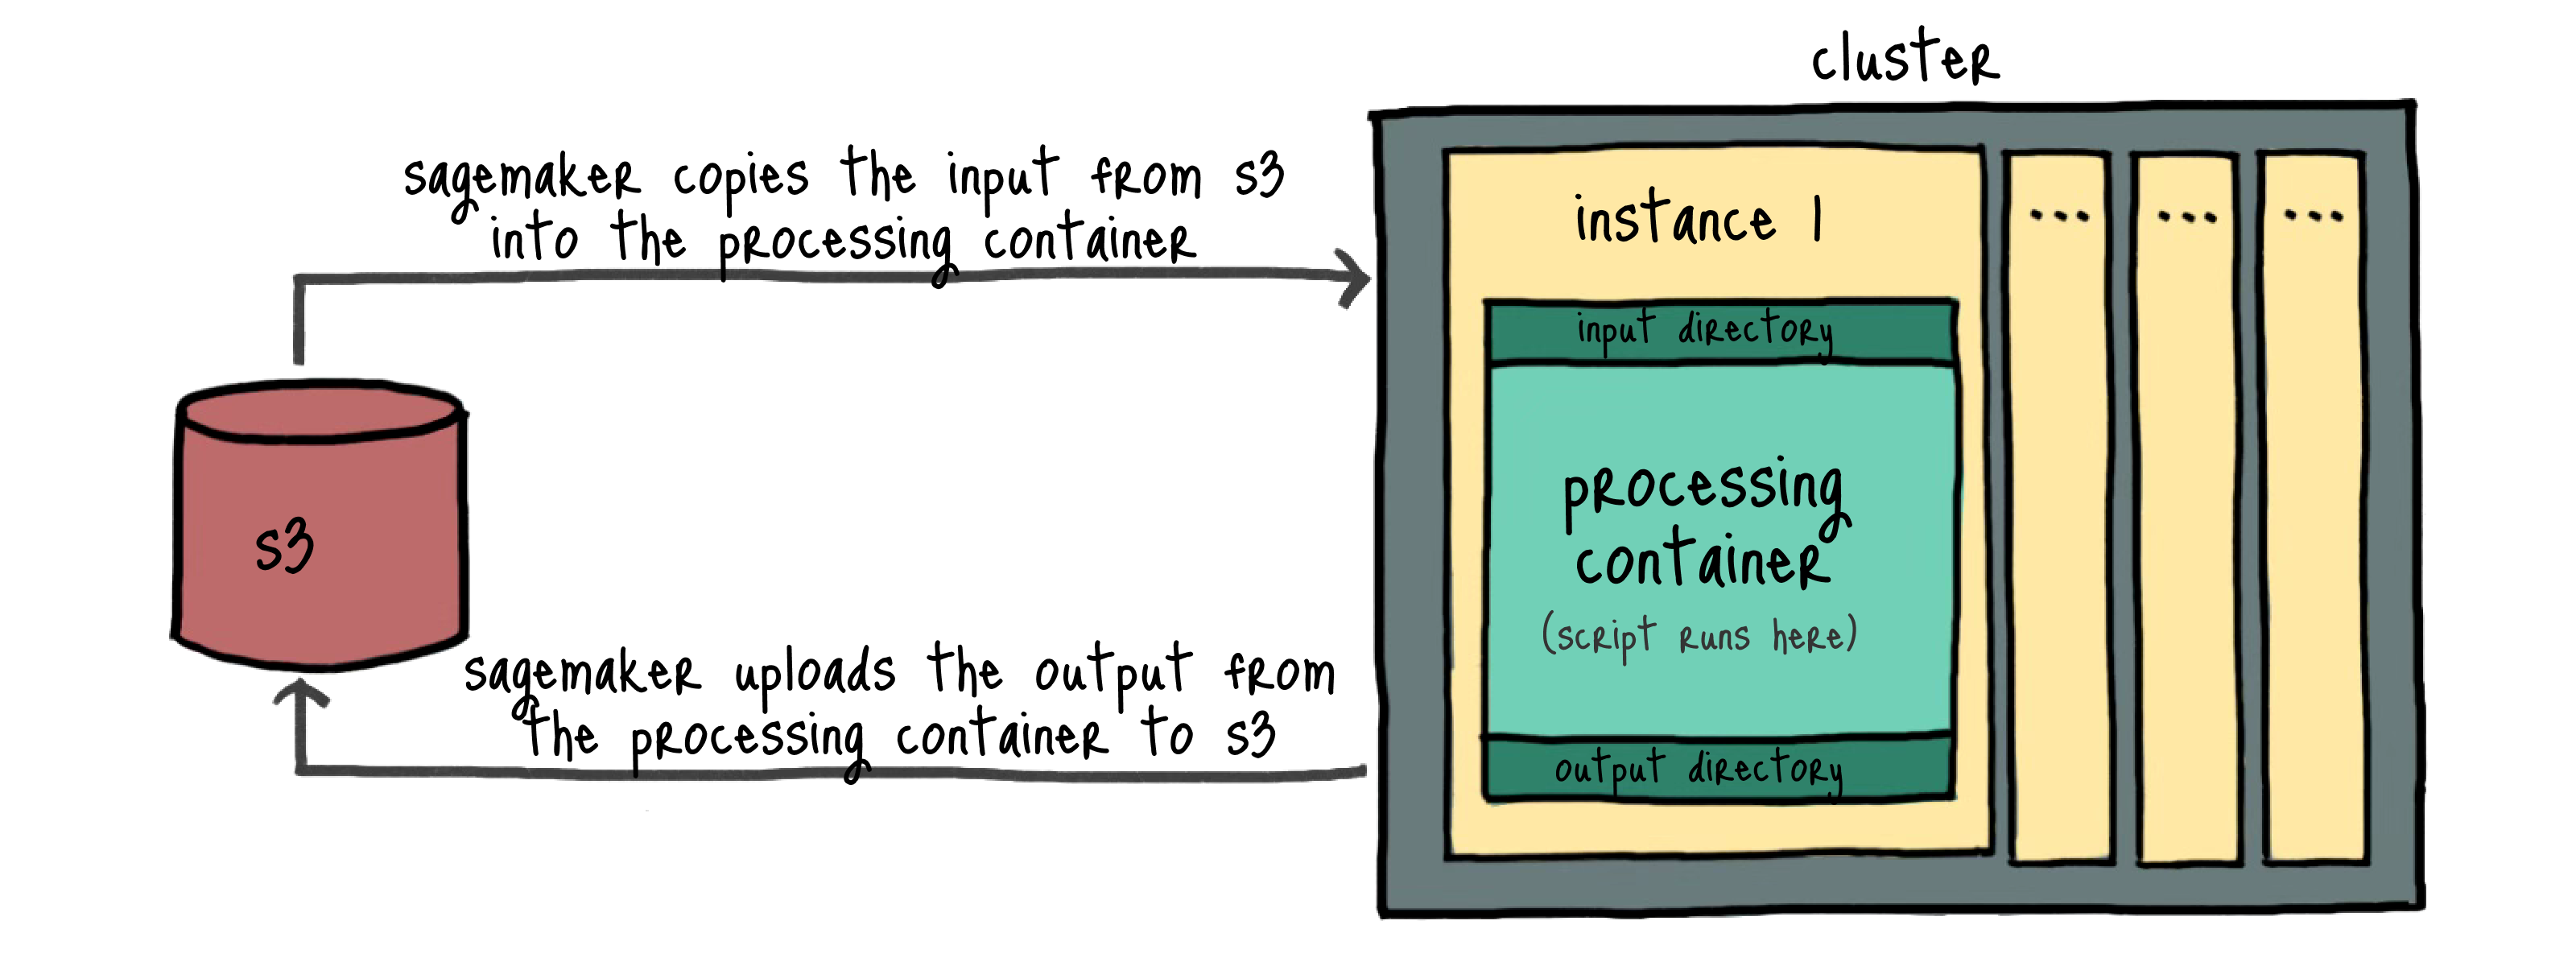

The Data Processing with Framework Processors page discusses other built-in processors you can use. The Docker Registry Paths and Example Code page contains information about the available framework versions for each region.

Data Processing with Framework Processors - https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html

In [24]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

Let's now define the Processing Step that we'll use in the pipeline.

This step will specify the list of inputs that we'll access from the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.

In [25]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{(CODE_FOLDER / 'processing' / 'script.py').as_posix()}",
        inputs=[
            ProcessingInput(
                source=dataset_location,
                destination="/opt/ml/processing/input",
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

c:\Users\Vipul\miniconda3\envs\aws\lib\site-packages\sagemaker\workflow\pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


# Step 5 - Creating the Pipeline

We can now create the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [26]:
from sagemaker.workflow.pipeline import Pipeline

session3_pipeline = Pipeline(
    name="session3-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session3_pipeline.upsert(role_arn=role)

{'PipelineArn': 'session3-pipeline'}

#  Training the Model

This session extends the SageMaker Pipeline with a step to train a model. Check Train a Model with TensorFlow for more information about training a model with TensorFlow.

Links :

Train a model with TensorFlow : https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#train-a-model-with-tensorflow



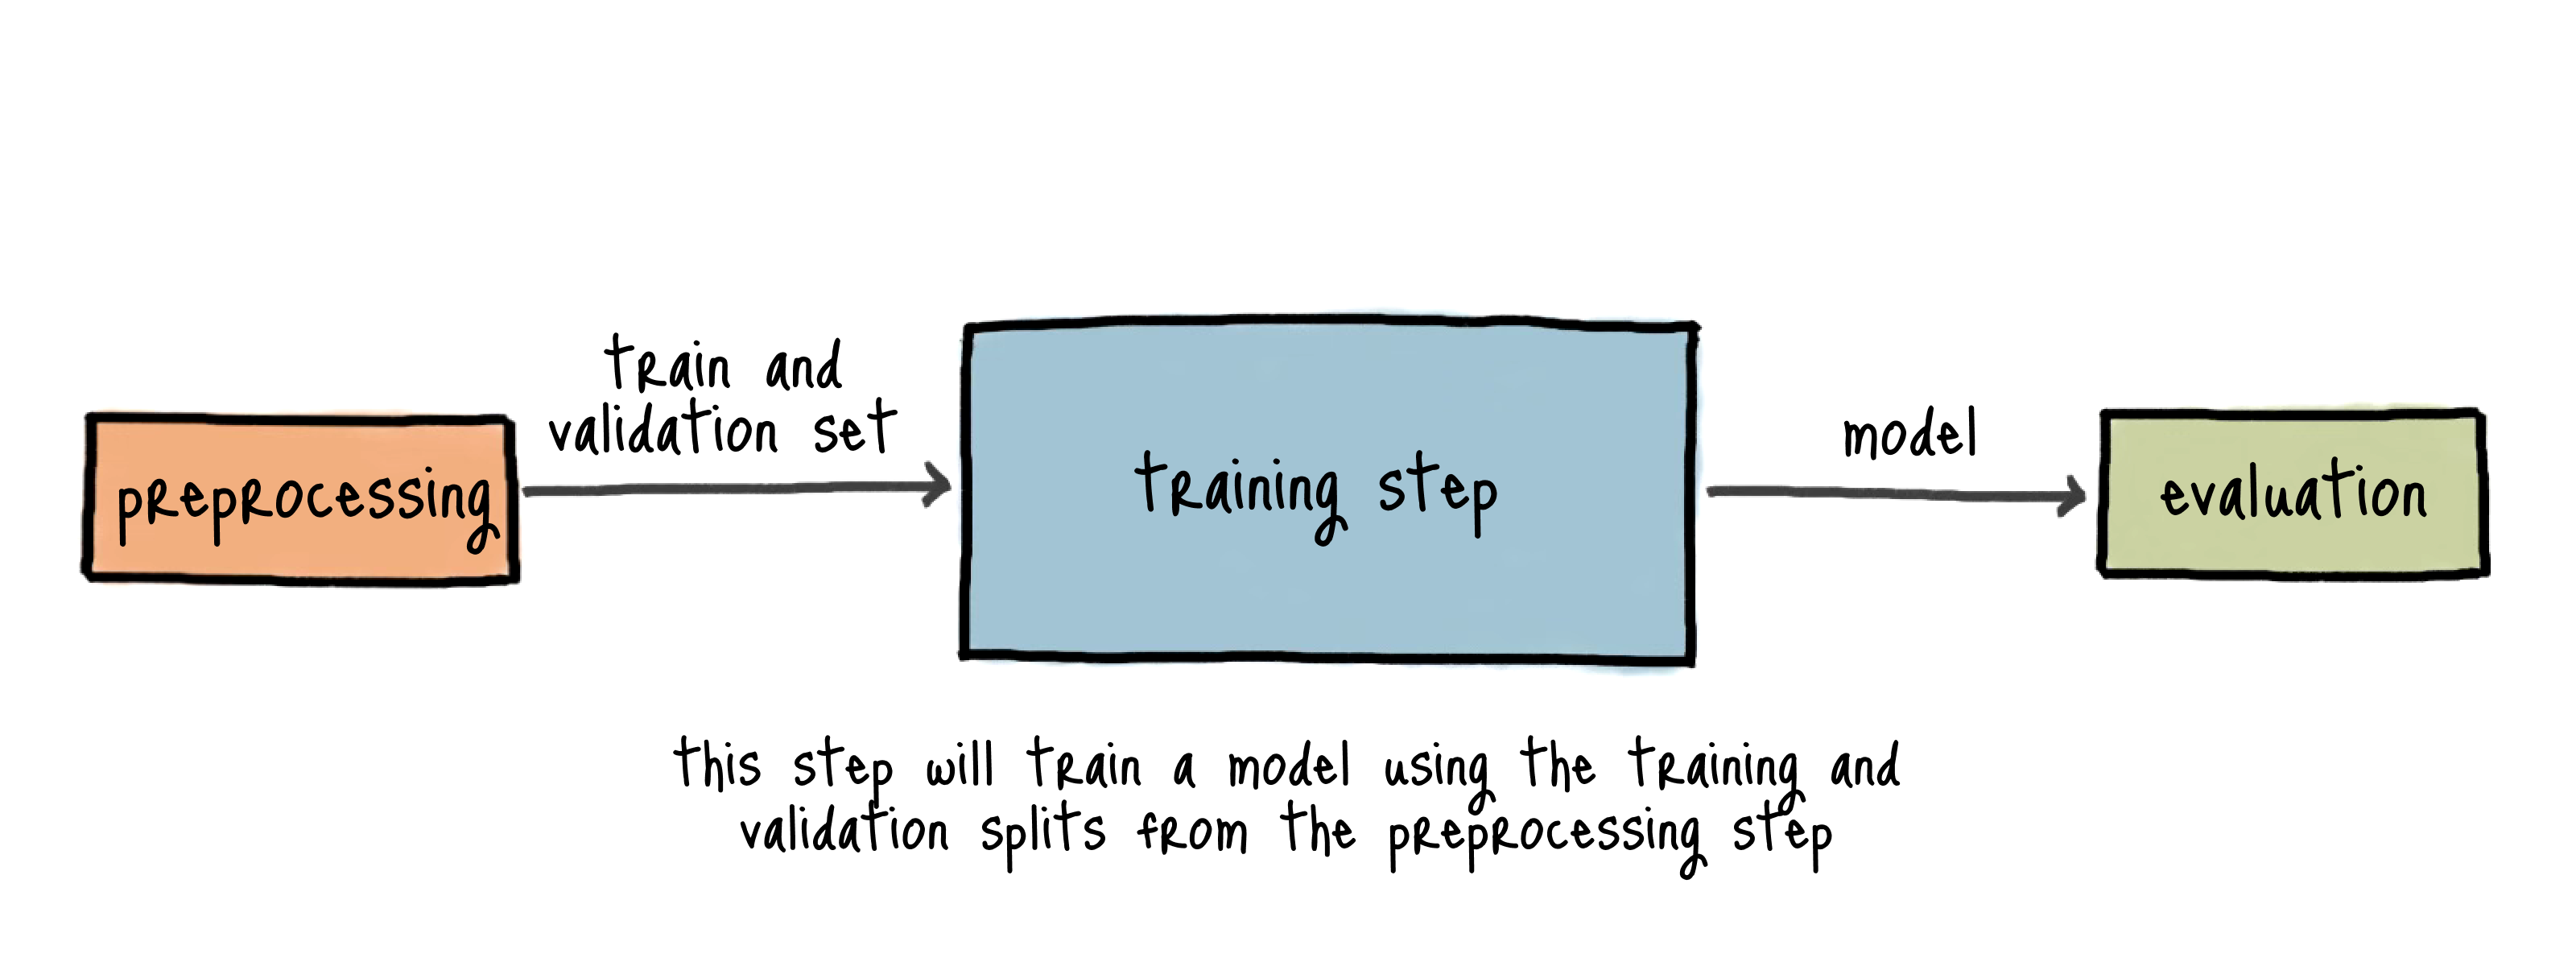

Experiment tracking will be done using Comet.

Step 1 - Creating the Training Script

Let's create the training script. This script is responsible for training a neural network using the train data, validating the model, and saving it so we can later use it.

We will store the script in a folder called training and add it to the system path so we can later import it as a module.

In [27]:
(CODE_FOLDER / "training").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/training"])

In [ ]:
%%writefile {CODE_FOLDER}/training/script.py
# | filename: script.py
# | code-line-numbers: true

import argparse
import json
import os
import tarfile
from pathlib import Path

import keras
import numpy as np
import pandas as pd
from comet_ml import Experiment
from keras import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from packaging import version
from sklearn.metrics import accuracy_score


def train(
    model_directory,
    train_path,
    validation_path,
    pipeline_path,
    experiment,
    epochs=50,
    batch_size=32,
):
    print(f"Keras version: {keras.__version__}")

    X_train = pd.read_csv(Path(train_path) / "train.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train = X_train.drop(X_train.columns[-1], axis=1)

    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation = X_validation.drop(X_validation.columns[-1], axis=1)

    model = Sequential(
        [
            Input(shape=(X_train.shape[1],)),
            Dense(10, activation="relu"),
            Dense(8, activation="relu"),
            Dense(3, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_validation, y_validation),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
    )

    predictions = np.argmax(model.predict(X_validation), axis=-1)
    val_accuracy = accuracy_score(y_validation, predictions)
    print(f"Validation accuracy: {val_accuracy}")

    # Starting on version 3, Keras changed the model saving format.
    # Since we are running the training script using two different versions
    # of Keras, we need to check to see which version we are using and save
    # the model accordingly.
    model_filepath = (
        Path(model_directory) / "001"
        if version.parse(keras.__version__) < version.parse("3")
        else Path(model_directory) / "penguins.keras"
    )

    model.save(model_filepath)

    # Let's save the transformation pipelines inside the
    # model directory so they get bundled together.
    with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
        tar.extractall(model_directory)

    if experiment:
        experiment.log_parameters(
            {
                "epochs": epochs,
                "batch_size": batch_size,
            }
        )
        experiment.log_dataset_hash(X_train)
        experiment.log_confusion_matrix(
            y_validation.astype(int), predictions.astype(int)
        )
        experiment.log_model("penguins", model_filepath.as_posix())


if __name__ == "__main__":
    # Any hyperparameters provided by the training job are passed to
    # the entry point as script arguments.
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    args, _ = parser.parse_known_args()

    # Let's create a Comet experiment to log the metrics and parameters
    # of this training job.
    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)

    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=True,
            auto_param_logging=True,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )

    training_env = json.loads(os.environ.get("SM_TRAINING_ENV", {}))
    job_name = training_env.get("job_name", None) if training_env else None

    # We want to use the SageMaker's training job name as the name
    # of the experiment so we can easily recognize it.
    if job_name and experiment:
        experiment.set_name(job_name)

    train(
        # This is the location where we need to save our model.
        # SageMaker will create a model.tar.gz file with anything
        # inside this directory when the training script finishes.
        model_directory=os.environ["SM_MODEL_DIR"],
        # SageMaker creates one channel for each one of the inputs
        # to the Training Step.
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE"],
        experiment=experiment,
        epochs=args.epochs,
        batch_size=args.batch_size,
    )

In [ ]:
# Testing

%%ipytest -s
#| code-fold: true

import os
import shutil
import pytest
import tempfile

from processing.script import preprocess
from training.script import train

@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1
    )
    
    yield directory
    
    shutil.rmtree(directory)


def test_train_bundles_model_assets(directory):
    bundle = os.listdir(directory / "model")
    assert "001" in bundle
    
    assets = os.listdir(directory / "model" / "001")
    assert "saved_model.pb" in assets


def test_train_bundles_transformation_pipelines(directory):
    bundle = os.listdir(directory / "model")
    assert "target.joblib" in bundle
    assert "features.joblib" in bundle

Step 2 - Setting up the Training Step

We can now create a Training Step that we can add to the pipeline. This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the TrainingStep SageMaker's SDK documentation for more information.

SageMaker manages the infrastructure of a Training Job. It provisions resources for the duration of the job, and cleans up when it completes. The Training Container image that SageMaker uses to run a Training Job can either be a SageMaker built-in image or a custom image.


Training Step link : https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep

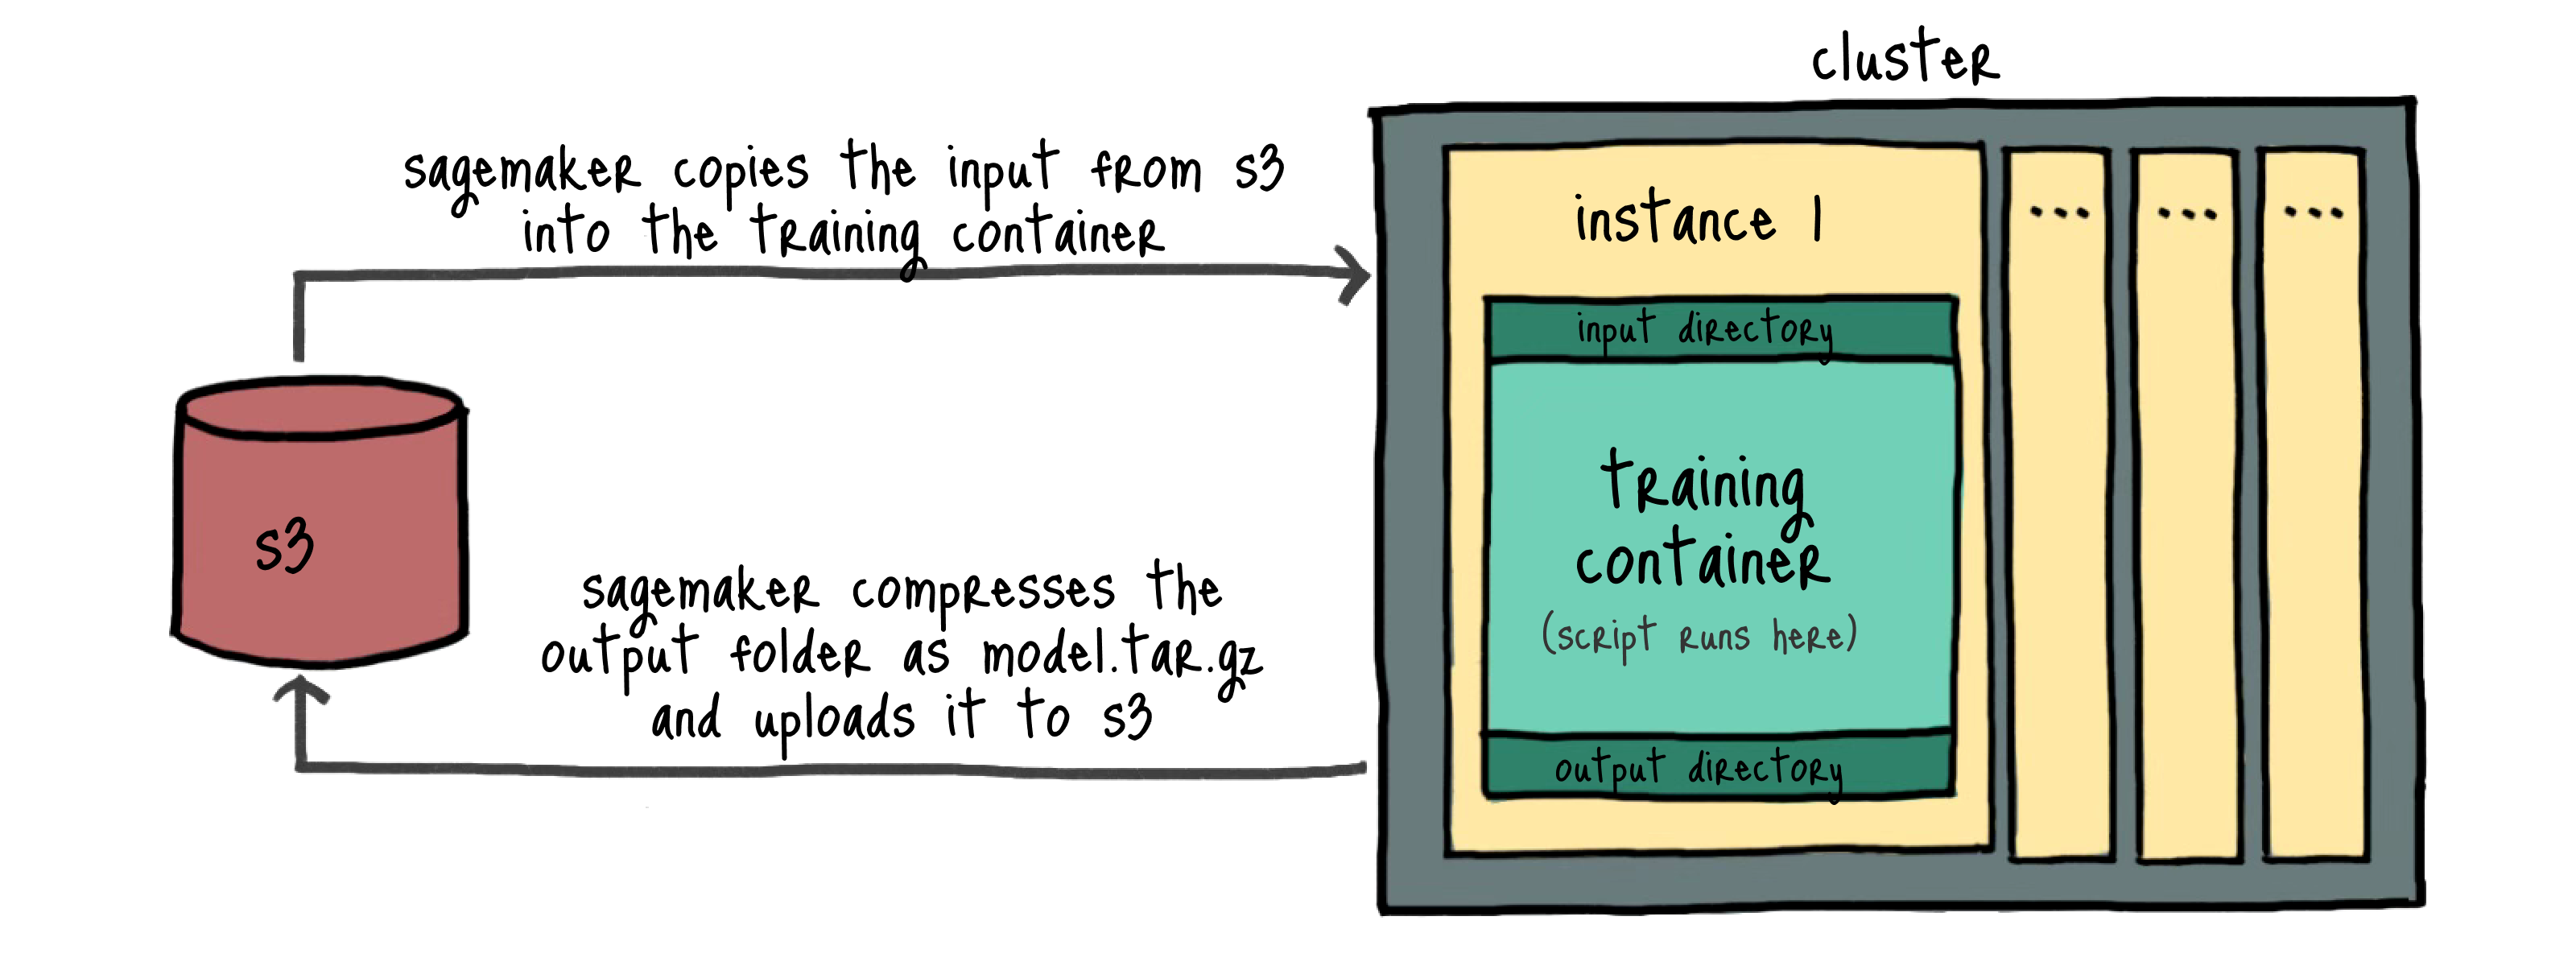

The Available Deep Learning Container Images page contains the list of available containers for each region.

Our training script uses Comet to track metrics from the Training Job. We need to create a requirements.txt file to install the Comet library in the training container.



In [ ]:
%%writefile {CODE_FOLDER}/training/requirements.txt
#| label: requirements.txt
#| filename: requirements.txt
#| code-line-numbers: false

comet_ml

SageMaker uses the concept of an Estimator to handle end-to-end training and deployment tasks. For this example, we will use the built-in TensorFlow Estimator to run the training script we wrote before.

Notice the list of hyperparameters defined below. SageMaker will pass these hyperparameters as arguments to the entry point of the training script.

We are going to use Comet and SageMaker Experiments to track metrics from the Training Job. SageMaker Experiments will use the list of metric definitions to decide which metrics to track and how to parse them from the Training Job logs. For more information, check Manage Machine Learning with Amazon SageMaker Experiments and the SageMaker Experiments' SDK documentation.

Here are the environment variables we need to set on the traininng container:

COMET_API_KEY: This is your Comet API key.
COMET_PROJECT_NAME: The name of the project where you want to track the experiments.

Links :

Estimator : https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html

Tensorflow Estimator : https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator



In [ ]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name="training",
    entry_point="script.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    # SageMaker will pass these hyperparameters as arguments
    # to the entry point of the training script.
    hyperparameters={
        "epochs": 50,
        "batch_size": 32,
    },
    # SageMaker will create these environment variables on the
    # Training Job instance.
    environment={
        "COMET_API_KEY": COMET_API_KEY,
        "COMET_PROJECT_NAME": COMET_PROJECT_NAME,
    },
    # SageMaker will track these metrics as part of the experiment
    # associated to this pipeline. The metric definitions tells
    # SageMaker how to parse the values from the Training Job logs.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    disable_profiler=True,
    debugger_hook_config=False,
    sagemaker_session=config["session"],
    role=role,
)

We can now create a Training Step. This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the TrainingStep SageMaker's SDK documentation for more information.

This step will receive the train and validation split from the preprocessing step as inputs.

Here, we are using three input channels, train, validation, and pipeline. SageMaker will automatically create an environment variable corresponding to each of these channels following the format SM_CHANNEL_[channel_name]:

SM_CHANNEL_TRAIN: This environment variable will contain the path to the training data coming from the preprocessing step.
SM_CHANNEL_VALIDATION: This environment variable will contain the path to the validation data comimng from the preprocessing step.
SM_CHANNEL_PIPELINE: This environment variable will contain the path to the transformation pipeline that we saved in the preprocessing step.
Notice that we are creating a function that we can later reuse to create a training step using a different estimator.

Training step : https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training

Trainingstep : https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep

In [ ]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


def create_training_step(estimator):
    """Create a SageMaker TrainingStep using the provided estimator."""
    return TrainingStep(
        name="train-model",
        step_args=estimator.fit(
            inputs={
                "train": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "validation": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "validation"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "pipeline": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "model"
                    ].S3Output.S3Uri,
                    content_type="application/tar+gzip",
                ),
            },
        ),
        cache_config=cache_config,
    )


train_model_step = create_training_step(estimator)

Step 3 - Creating the Pipeline

In [ ]:
session4_pipeline = Pipeline(
    name="session4-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session4_pipeline.upsert(role_arn=role)

# 5 - Custom Training Container

This session creates a custom Docker image to train the model and have full control of the environment where the training script runs.

For this example, we'll run the training script using Keras 3 with a JAX backend. Check Adapting your own Docker container to work with SageMaker for more information about using your own Docker containers.


Link : https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers-adapt-your-own.html

### Step 1 - Preparing the Docker Image

The first step is to copy the training script to a folder where we'll prepare the Docker image. We are going to reuse the training script we created before, since it's compatible with the latest version of Keras.

In [ ]:
import shutil

(CODE_FOLDER / "containers" / "training").mkdir(parents=True, exist_ok=True)
shutil.copy2(
    CODE_FOLDER / "training" / "script.py",
    CODE_FOLDER / "containers" / "training" / "train.py",
)

Since we are creating a new Docker image, we need to install the libraries we need in the training container. We'll use a requirements.txt file to install these libraries. Notice that we are installing jax to run it as our backend.

The sagemaker-training library contains the common functionality necessary to create a container compatible with SageMaker and its Python SDK.

In [ ]:
%%writefile {CODE_FOLDER}/containers/training/requirements.txt
# | filename: requirements.txt
# | code-line-numbers: true

sagemaker-training
packaging
keras
pandas
scikit-learn
comet_ml
jax[cpu]

We can now create the Dockerfile containing the instructions to build the training image. Notice how this image will automatically run the train.py script when it starts.

To use JAX as the backend for our model, we need to set the KERAS_BACKEND environment variable to jax.

In [ ]:
%%writefile {CODE_FOLDER}/containers/training/Dockerfile

# | filename: Dockerfile
# | code-line-numbers: true

# Use the official Python image for Windows
FROM python:3.10-windowsservercore

# Install Python dependencies
COPY requirements.txt .
RUN pip install --user --upgrade pip
RUN pip3 install -r requirements.txt

# Copy the training script
COPY train.py C:\opt\ml\code\train.py

# Set environment variables
ENV SAGEMAKER_PROGRAM=train.py
ENV KERAS_BACKEND=jax


### Step 2 - Building the Docker Image

We can now build the Docker image using the docker build command. We are going to define the name of this image using the IMAGE_NAME variable.

In [ ]:
import subprocess

IMAGE_NAME = "keras-custom-training-container"

if not LOCAL_MODE:
    # If we aren't running the code in Local Mode, we need
    # to specify we want to build the Docker image for the
    # windows/amd64 architecture before uploading it to ECR.
    print("Building Docker image for windows/amd64 architecture...")

    subprocess.run(["docker", "build", "--platform", "windows/amd64", "-t", IMAGE_NAME,
                    os.path.join(CODE_FOLDER, "containers", "training")])
else:
    # If we are running in Local Mode, we can use the
    # default Docker build command.
    print("Building Docker image for arm64 architecture...")

    subprocess.run(["docker", "build", "-t", IMAGE_NAME,
                    os.path.join(CODE_FOLDER, "containers", "training")])


### Step 3 - Pushing Docker Image to ECR

We can now push the Docker image to Amazon Elastic Container Registry (ECR). This is a fully-managed Docker container registry where we can manage Docker container images. This step is necessary to make the image available to SageMaker when running the pipeline.

In [ ]:
%%bash -s "$LOCAL_MODE" "$IMAGE_NAME"
# | eval: false

algorithm_name=$2
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration
# (default to us-east-1 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

repository="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# We only want to push the Docker image to ECR if
# we are not running in Local Mode.
if [ $1 = "False" ]
then
    # Create the repository if it doesn't exist in ECR
    aws ecr describe-repositories \
        --repository-names "${algorithm_name}" > /dev/null 2>&1
    if [ $? -ne 0 ]
    then
        aws ecr create-repository \
            --repository-name "${algorithm_name}" > /dev/null
    fi

    # Get the login command from ECR to run the
    # Docker push command.
    aws ecr get-login-password \
        --region ${region}|docker \
        login --username AWS --password-stdin ${repository}

    # Push the Docker image to the ECR repository
    docker tag ${algorithm_name} ${repository}
    docker push ${repository}
fi

### Step 4 - Setting up the Training Step

Let's now compute the name of the training image we'll use to run the Training Job.

If we are running in LOCAL_MODE, we'll use the name of the image we built before (IMAGE_NAME). Otherwise, we'll use the name of the image we pushed to ECR.

In [ ]:
account_id = boto3.client("sts").get_caller_identity().get("Account")
tag = ":latest"

uri_suffix = "amazonaws.com"
if region in ["cn-north-1", "cn-northwest-1"]:
    uri_suffix = "amazonaws.com.cn"

training_container_image = (
    IMAGE_NAME
    if LOCAL_MODE
    else (f"{account_id}.dkr.ecr.{region}.amazonaws.com/{IMAGE_NAME}:latest")
)

training_container_image

We can now create an Estimator and a Training Step using the function we created before.

In [ ]:
from sagemaker.estimator import Estimator

keras_estimator = Estimator(
    image_uri=training_container_image,
    instance_count=1,
    instance_type=config["instance_type"],
    sagemaker_session=config["session"],
    role=role,
)

keras_train_model_step = create_training_step(keras_estimator)

### Step 5 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [ ]:
session5_pipeline = Pipeline(
    name="session5-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        # This time we want to use the new training step
        # we created using the custom Docker image.
        keras_train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session5_pipeline.upsert(role_arn=role)

# Session 6 - Tuning the Model

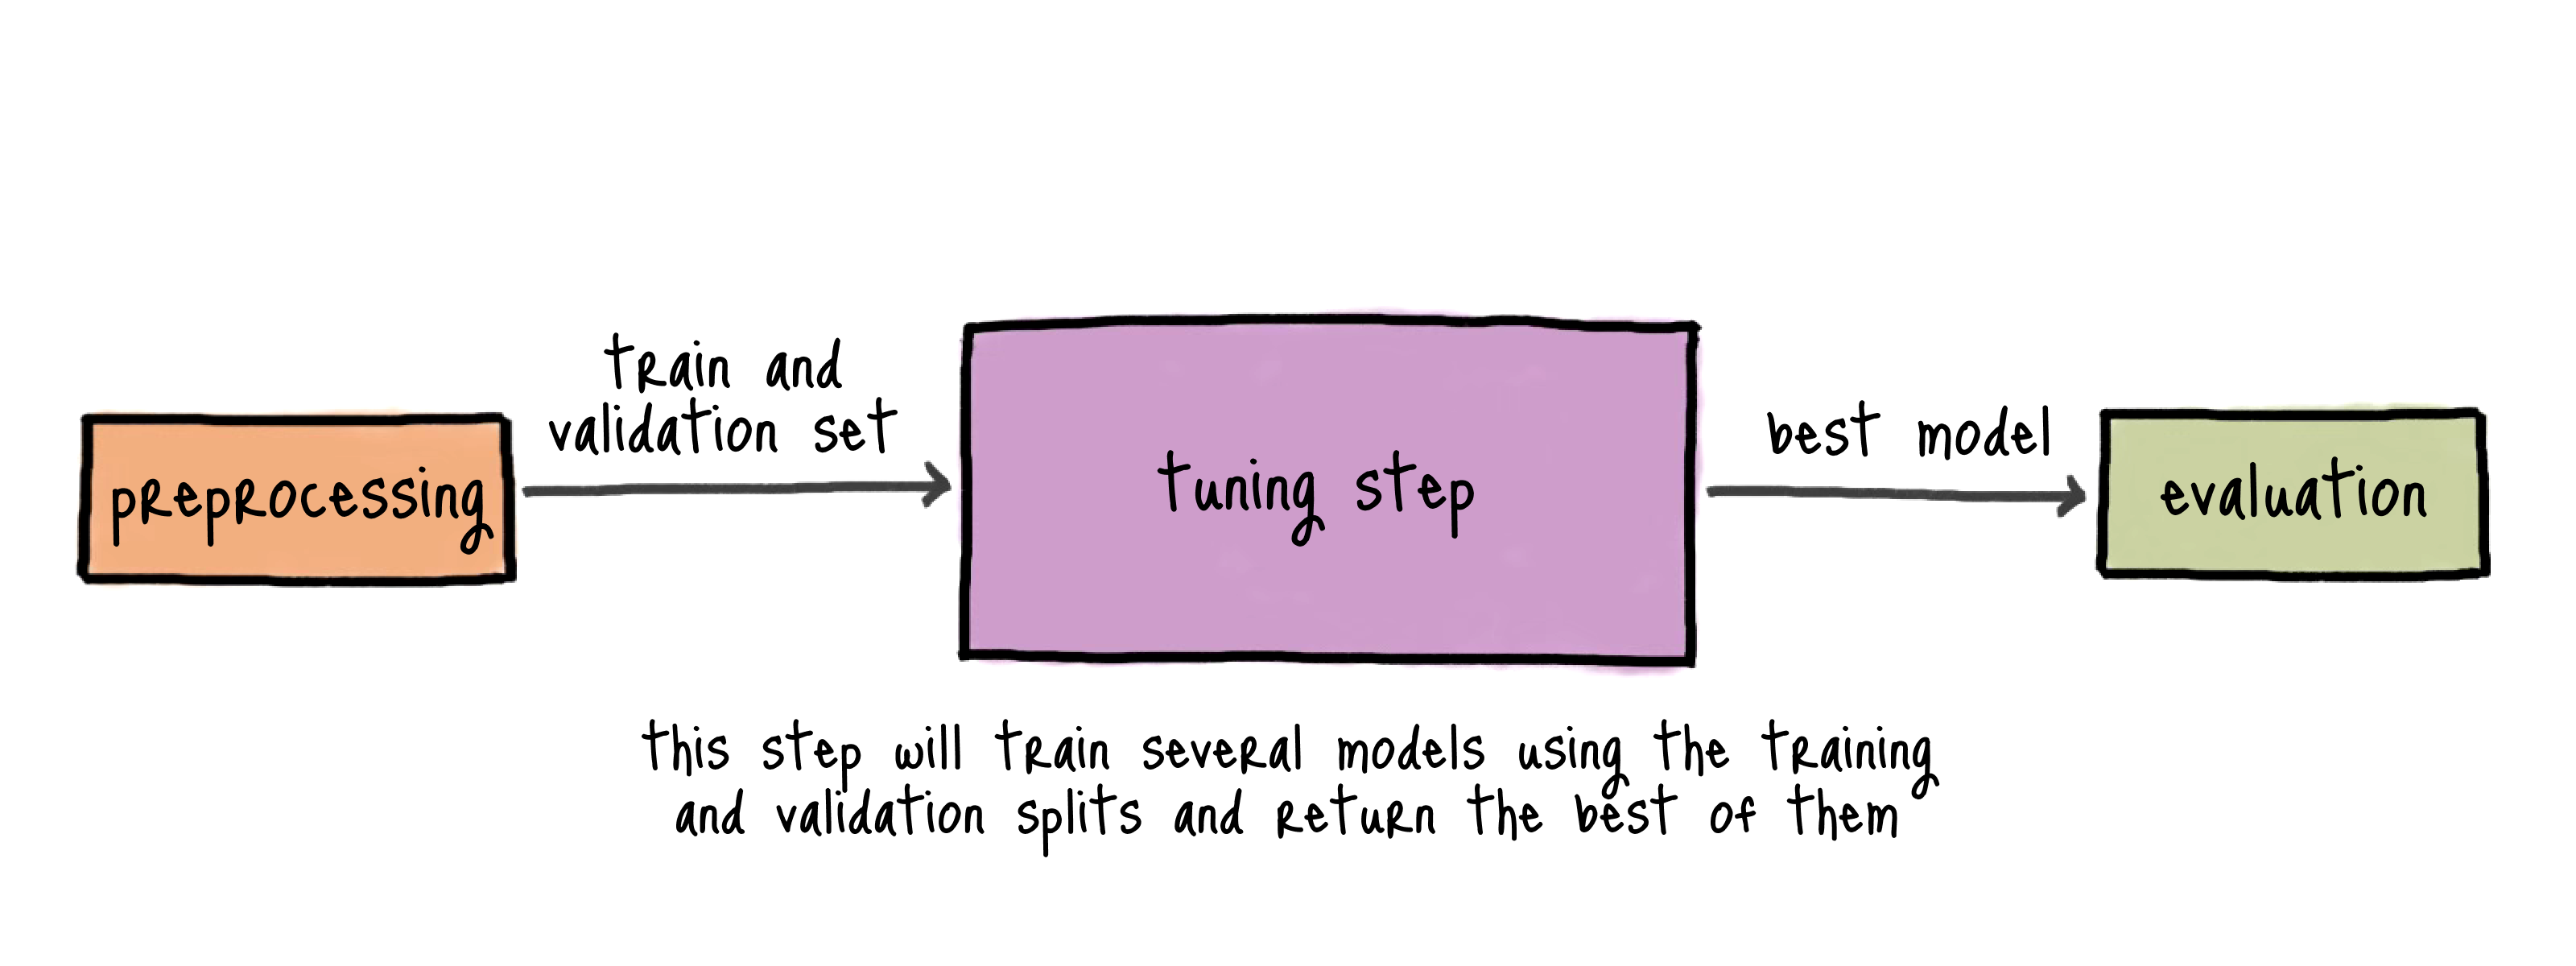

# Step 1 - Enabling Tuning

Since we could use the Training of the Tuning Step to create a model, we'll define a constant to indicate which approach we want to run. Notice that the Tuning Step is not supported in Local Mode.

In [ ]:
USE_TUNING_STEP = False

Step 2 - Setting up a Tuning Step

Let's now create a Tuning Step. This Tuning Step will create a SageMaker Hyperparameter Tuning Job in the background and use the training script to train different model variants and choose the best one. Check the TuningStep SageMaker's SDK documentation for more information.

The Tuning Step requires a HyperparameterTuner reference to configure the Hyperparameter Tuning Job.

Here is the configuration that we'll use to find the best model:

objective_metric_name: This is the name of the metric the tuner will use to determine the best model.
objective_type: This is the objective of the tuner. It specifies whether it should minimize the metric or maximize it. In this example, since we are using the validation accuracy of the model, we want the objective to be "Maximize." If we were using the loss of the model, we would set the objective to "Minimize."
metric_definitions: Defines how the tuner will determine the metric's value by looking at the output logs of the training process.
The tuner expects the list of the hyperparameters you want to explore. You can use subclasses of the Parameter class to specify different types of hyperparameters. This example explores different values for the epochs hyperparameter.

Finally, you can control the number of jobs and how many of them will run in parallel using the following two arguments:

max_jobs: Defines the maximum total number of training jobs to start for the hyperparameter tuning job.

max_parallel_jobs: Defines the maximum number of parallel training jobs to start.

Tuning step - https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning

Tuningstep : https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep

Hyperparametertuner : https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html

Parameter : https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html#sagemaker.parameter.ParameterRange

In [ ]:
from sagemaker.parameter import IntegerParameter
from sagemaker.tuner import HyperparameterTuner

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges={
        "epochs": IntegerParameter(10, 50),
    },
    metric_definitions=[{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}],
    max_jobs=3,
    max_parallel_jobs=3,
)

We can now create the Tuning Step using the tuner we configured before. SageMaker will create a Hyperparameter Tuning Job in the background and use the training script to train different model variants and choose the best one.

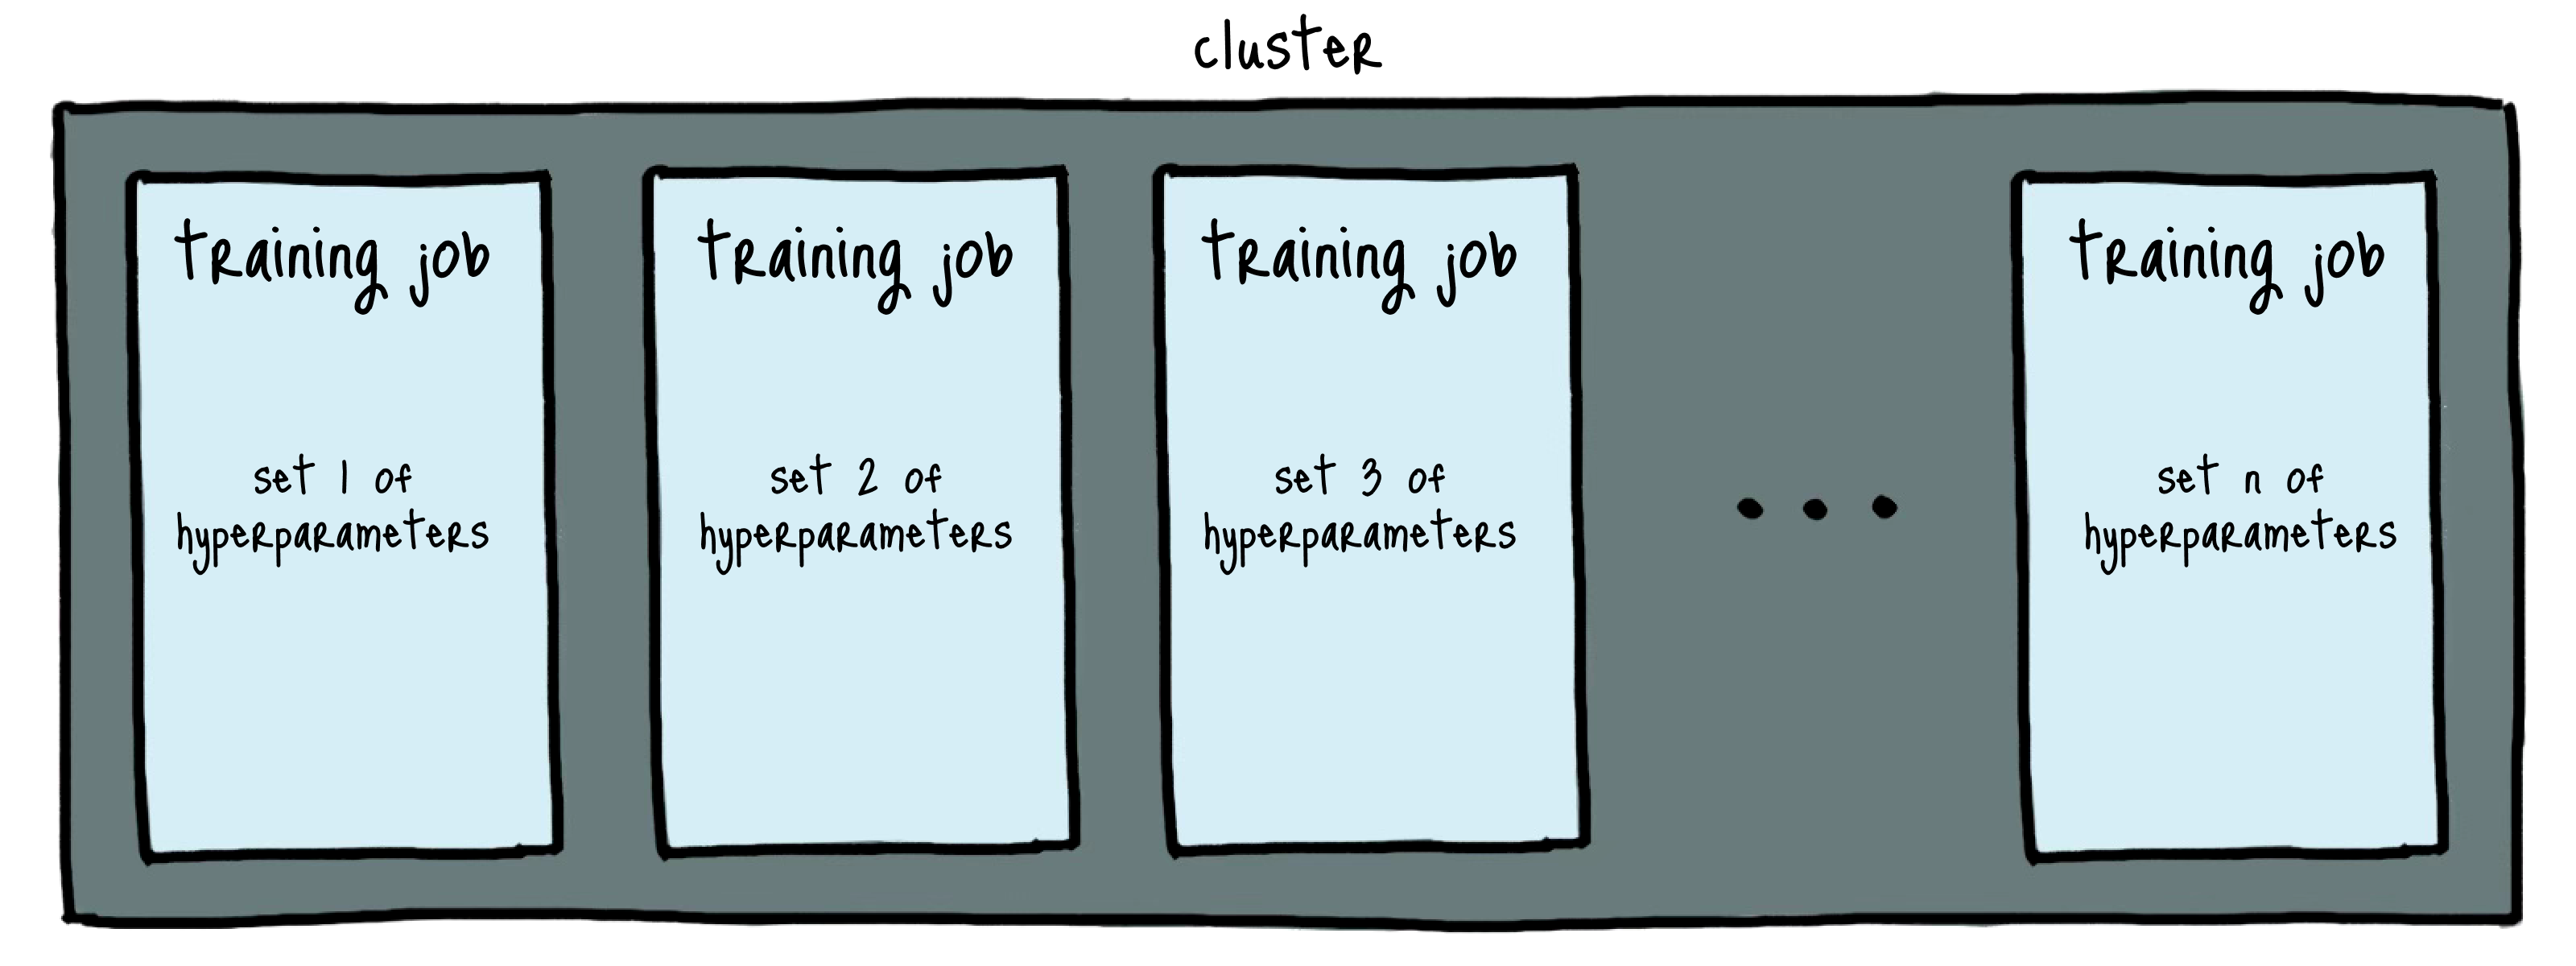

In [ ]:
from sagemaker.workflow.steps import TuningStep

tune_model_step = TuningStep(
    name="tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "pipeline": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "model"
                ].S3Output.S3Uri,
                content_type="application/tar+gzip",
            ),
        },
    ),
    cache_config=cache_config,
)

# Step 3 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [ ]:
session6_pipeline = Pipeline(
    name="session6-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session6_pipeline.upsert(role_arn=role)

## Evaluating the Model

This session extends the SageMaker Pipeline with a step to evaluate the model using the holdout set we created during the preprocessing step.

### Step 1 - Creating the Evaluation Script

We'll use a Processing Step to execute the evaluation script.

This script is responsible for loading the model we created and evaluating it on the test set. Before finishing, this script will generate an evaluation report of the model.

We will store the script in a folder called evaluation and add it to the system path so we can later import it as a module.

In [ ]:
(CODE_FOLDER / "evaluation").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/evaluation"])

We can now create the script inside the folder:

In [ ]:
%%writefile {CODE_FOLDER}/evaluation/script.py
# | filename: script.py
# | code-line-numbers: true

import json
import tarfile
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow import keras


def evaluate(model_path, test_path, output_path):
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test = X_test.drop(X_test.columns[-1], axis=1)

    # Let's now extract the model package so we can load
    # it in memory.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))

    model = keras.models.load_model(Path(model_path) / "001")

    predictions = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test accuracy: {accuracy}")

    # Let's create an evaluation report using the model accuracy.
    evaluation_report = {
        "metrics": {
            "accuracy": {"value": accuracy},
        },
    }

    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))


if __name__ == "__main__":
    evaluate(
        model_path="/opt/ml/processing/model/",
        test_path="/opt/ml/processing/test/",
        output_path="/opt/ml/processing/evaluation/",
    )

### Step 2 - Referencing the Model Assets

One of the inputs to the evaluation step is the model coming from the Training or the Tuning step. We can use the USE_TUNING_STEP flag to determine whether we created the model using a Training Step or a Tuning Step.

In case we are using the Tuning Step, we can use the TuningStep.get_top_model_s3_uri() function to get the model assets from the top performing training job of the Hyperparameter Tuning Job.

In [ ]:
model_assets = train_model_step.properties.ModelArtifacts.S3ModelArtifacts

if USE_TUNING_STEP:
    model_assets = tune_model_step.get_top_model_s3_uri(
        top_k=0,
        s3_bucket=config["session"].default_bucket(),
    )

### Step 3 - Mapping the Output to a Property File


SageMaker supports mapping outputs from a Processing Step to property files. This is useful when we want to access a specific property from the pipeline.

We'll map the evaluation report to a property file. Check How to Build and Manage Property Files for more information.

How to Build and Manage Property Files :

Link :https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-propertyfile.html

In [ ]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation",
    path="evaluation.json",
)

### Step 4 - Setting up the Evaluation Step

To run the evaluation script, we will use a Processing Step configured with a TensorFlowProcessor because the script needs access to TensorFlow.

Processing step : https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing

TensorFlowProcessor : https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks-tensorflow.html

In [ ]:
from sagemaker.tensorflow import TensorFlowProcessor

evaluation_processor = TensorFlowProcessor(
    base_job_name="evaluation-processor",
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

We are now ready to define the Processing Step that will run the evaluation script:

Processing Step : https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep

In [ ]:
evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=evaluation_processor.run(
        code=f"{(CODE_FOLDER / 'evaluation' / 'script.py').as_posix()}",
        inputs=[
            # The first input is the test split that we generated on
            # the first step of the pipeline when we split and
            # transformed the data.
            ProcessingInput(
                source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
            # The second input is the model that we generated on
            # the Training or Tunning Step.
            ProcessingInput(
                source=model_assets,
                destination="/opt/ml/processing/model",
            ),
        ],
        outputs=[
            # The output is the evaluation report that we generated
            # in the evaluation script.
            ProcessingOutput(
                output_name="evaluation",
                source="/opt/ml/processing/evaluation",
            ),
        ],
    ),
    property_files=[evaluation_report],
    cache_config=cache_config,
)

### Step 5 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.



In [ ]:
session7_pipeline = Pipeline(
    name="session7-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session7_pipeline.upsert(role_arn=role)

## Session 8 - Registering the Model

This session extends the SageMaker Pipeline with a step to register the model in the SageMaker Model Registry.

SageMaker Pipeline : https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html

SageMaker Model Registry : https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html

Registering the Model : https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html

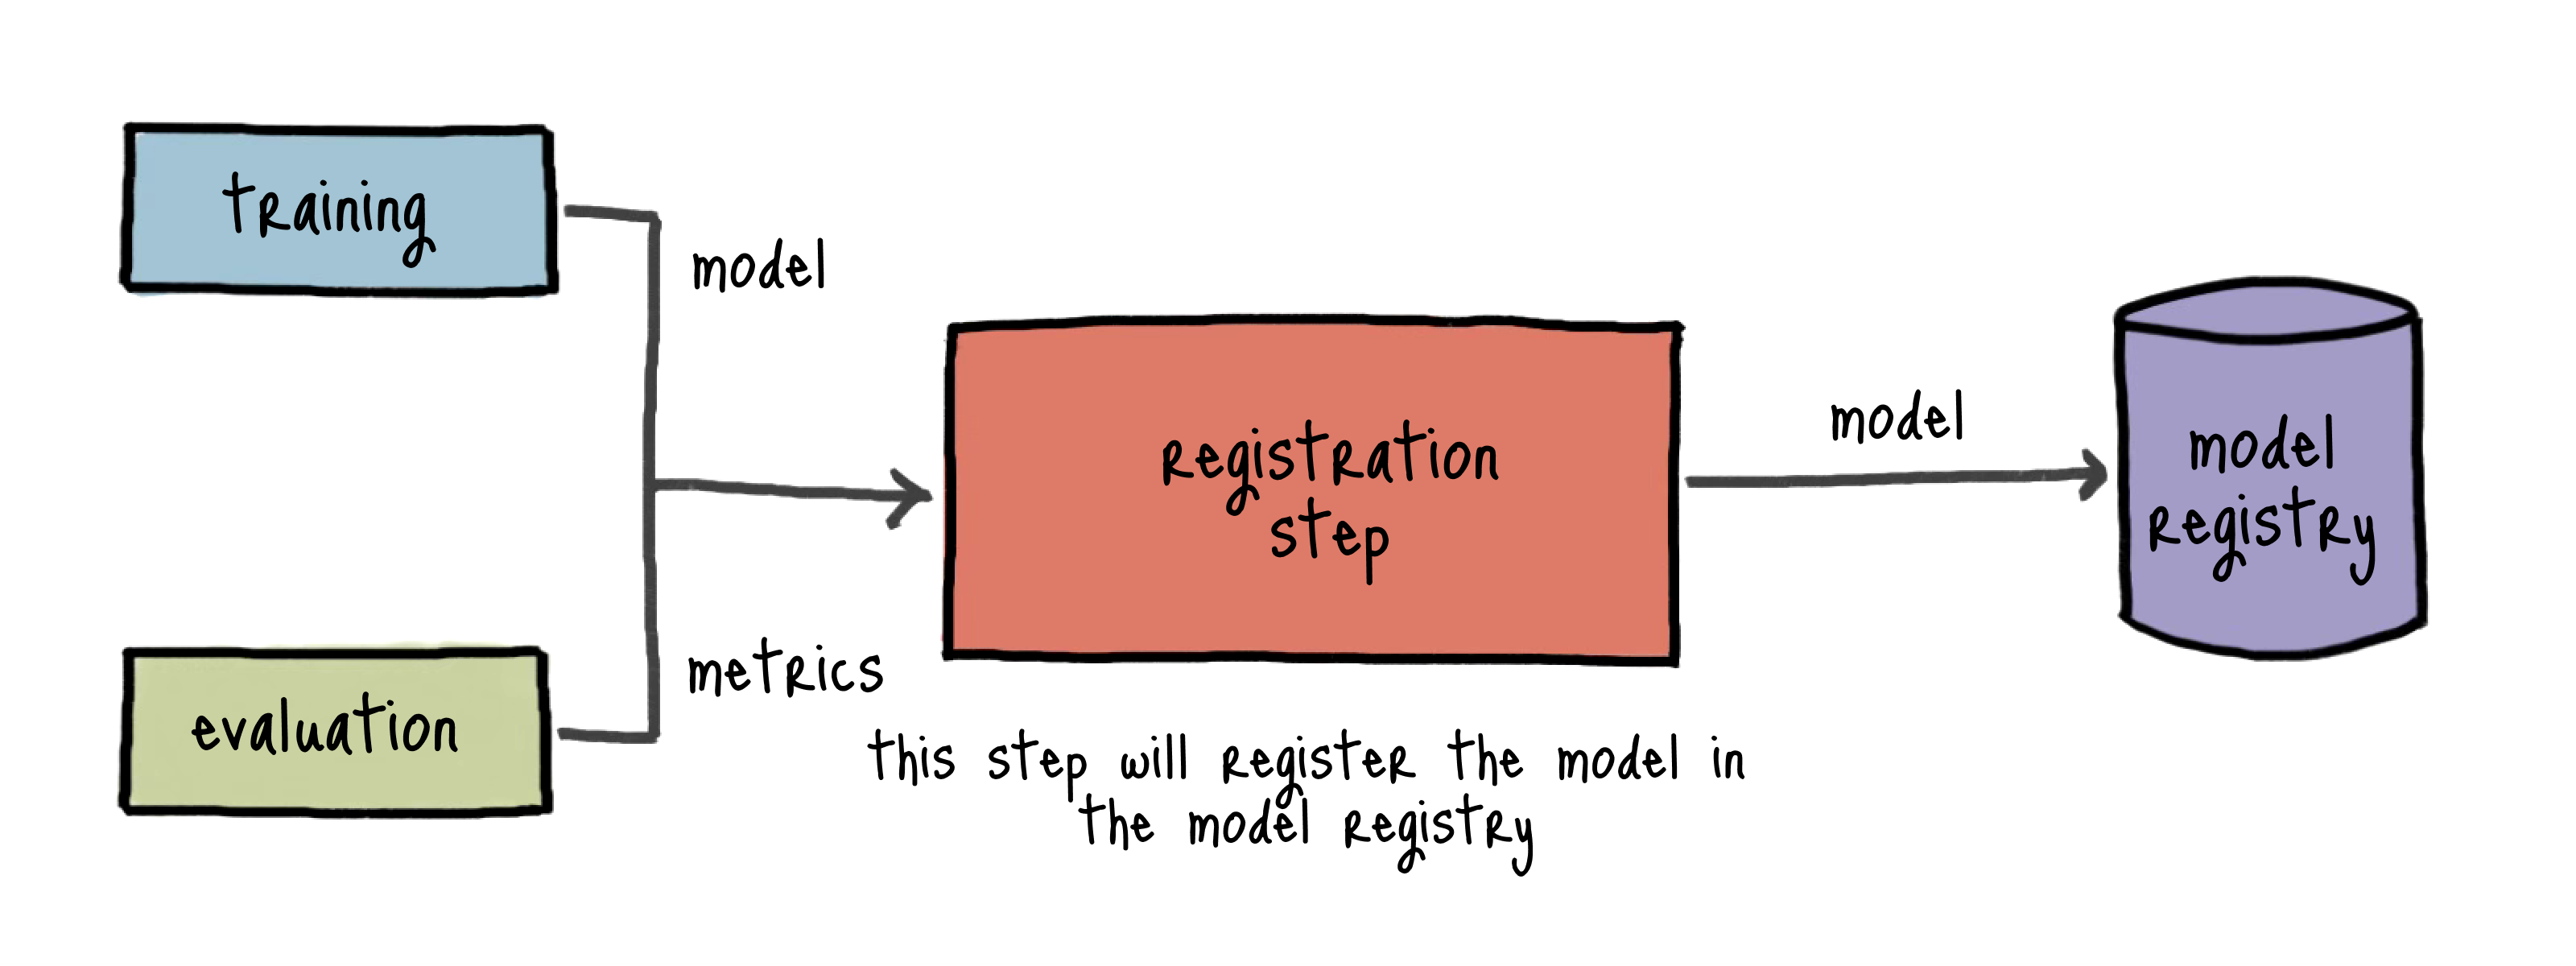

### Step 1 - Configuring the Model Package Group

First, let's define the name of the group where we'll register the model. The Model Registry uses groups to organize the versions of a model:

In [ ]:
BASIC_MODEL_PACKAGE_GROUP = "basic-penguins"

### Step 2 - Creating the Model

Let's now create the model that we'll register in the Model Registry. The model we trained uses TensorFlow, so we can use the built-in TensorFlowModel class to create an instance of the model:


TensorFlowModel class : https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model

In [ ]:
from sagemaker.tensorflow.model import TensorFlowModel

tensorflow_model = TensorFlowModel(
    model_data=model_assets,
    framework_version=config["framework_version"],
    sagemaker_session=config["session"],
    role=role,
)

### Step 3 - Configuring Model Metrics
When we register a model in the Model Registry, we can attach relevant metadata to it. We'll use the evaluation report we generated during the evaluation step to populate the metrics of this model

Metrics : https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics

In [ ]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.functions import Join

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(
            on="/",
            values=[
                evaluate_model_step.properties.ProcessingOutputConfig.Outputs[
                    "evaluation"
                ].S3Output.S3Uri,
                "evaluation.json",
            ],
        ),
        content_type="application/json",
    ),
)

### Step 4 - Registering the Model
We can use a Model Step to register the model. Check the ModelStep SageMaker's SDK documentation for more information.

Model step : https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model

Modelstep : https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep

In [ ]:
from sagemaker.workflow.model_step import ModelStep


def create_registration_step(
    model,
    model_package_group_name,
    approval_status="Approved",
    content_types=["text/csv"],
    response_types=["application/json"],
    model_metrics=None,
    drift_check_baselines=None,
):
    """Create a Registration Step using the supplied parameters."""
    return ModelStep(
        name="register",
        step_args=model.register(
            model_package_group_name=model_package_group_name,
            approval_status=approval_status,
            model_metrics=model_metrics,
            drift_check_baselines=drift_check_baselines,
            content_types=content_types,
            response_types=response_types,
            inference_instances=[config["instance_type"]],
            transform_instances=[config["instance_type"]],
            framework_version=config["framework_version"],
            domain="MACHINE_LEARNING",
            task="CLASSIFICATION",
            framework="TENSORFLOW",
        ),
    )


register_model_step = create_registration_step(
    tensorflow_model,
    BASIC_MODEL_PACKAGE_GROUP,
    model_metrics=model_metrics,
)

### Step 5 - Creating the Pipeline
Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [ ]:
session8_pipeline = Pipeline(
    name="session8-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        register_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session8_pipeline.upsert(role_arn=role)

## Session 9 - Conditional Registration
This session extends the SageMaker Pipeline with a condition to register the model only if its accuracy is above a predefined threshold.

Here's a high-level overview of the Condition Step:

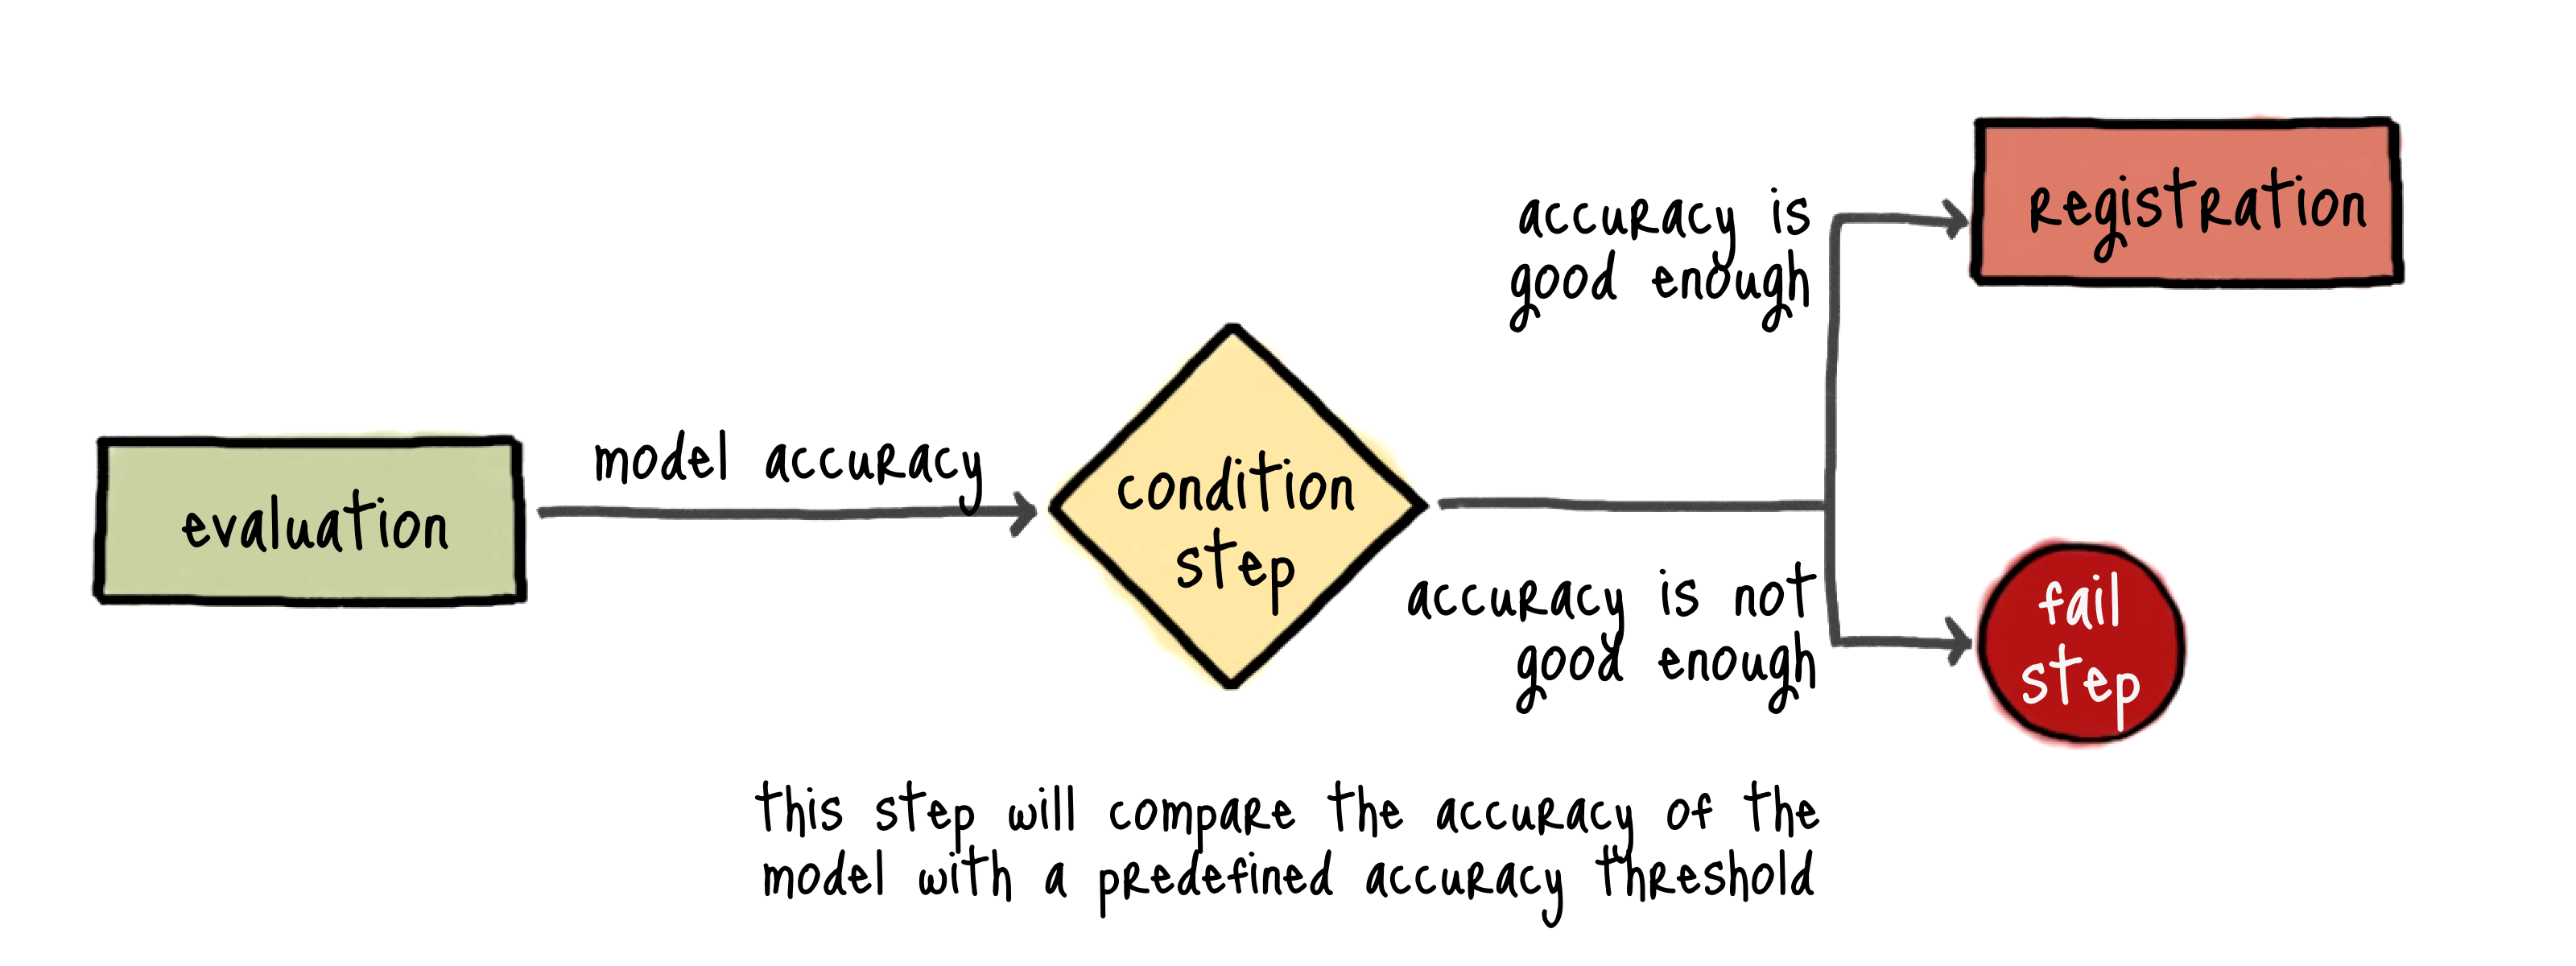

### Step 1 - Configuring the Accuracy Threshold
Let's define a new Pipeline Parameter to specify the minimum accuracy that the model should reach for it to be registered.

Pipeline Parameter : https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html

In [ ]:
from sagemaker.workflow.parameters import ParameterFloat

accuracy_threshold = ParameterFloat(name="accuracy_threshold", default_value=0.70)

### Step 2 - Setting up a Fail Step
If the model's accuracy is not greater than or equal to our threshold, we will send the pipeline to a Fail Step with the appropriate error message. Check the FailStep SageMaker's SDK documentation for more information.

Fail Step : https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-fail

failStep : https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep

In [ ]:
from sagemaker.workflow.fail_step import FailStep

fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ",
        values=[
            "Execution failed because the model's accuracy was lower than",
            accuracy_threshold,
        ],
    ),
)


### Step 3 - Defining the Condition
We can use a ConditionGreaterThanOrEqualTo condition to compare the model's accuracy with the threshold. Look at the Conditions section in the documentation for more information about the types of supported conditions.

ConditionGreaterThanOrEqualTo : https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.conditions.ConditionGreaterThanOrEqualTo

Conditions : https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#conditions

In [ ]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.functions import JsonGet

condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value",
    ),
    right=accuracy_threshold,
)

### Step 4 - Setting up the Condition Step
Let's now use a Condition Step together with the evaluation report we generated to determine whether the model's accuracy is above the threshold:

Condition Step : https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition

In [ ]:
from sagemaker.workflow.condition_step import ConditionStep

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step],
    else_steps=[fail_step],
)

### Step 5 - Creating the Pipeline
We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [ ]:
session9_pipeline = Pipeline(
    name="session9-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session9_pipeline.upsert(role_arn=role)

## Session 10 - Serving the Model
This session builds a simple Flask application to serve the model.

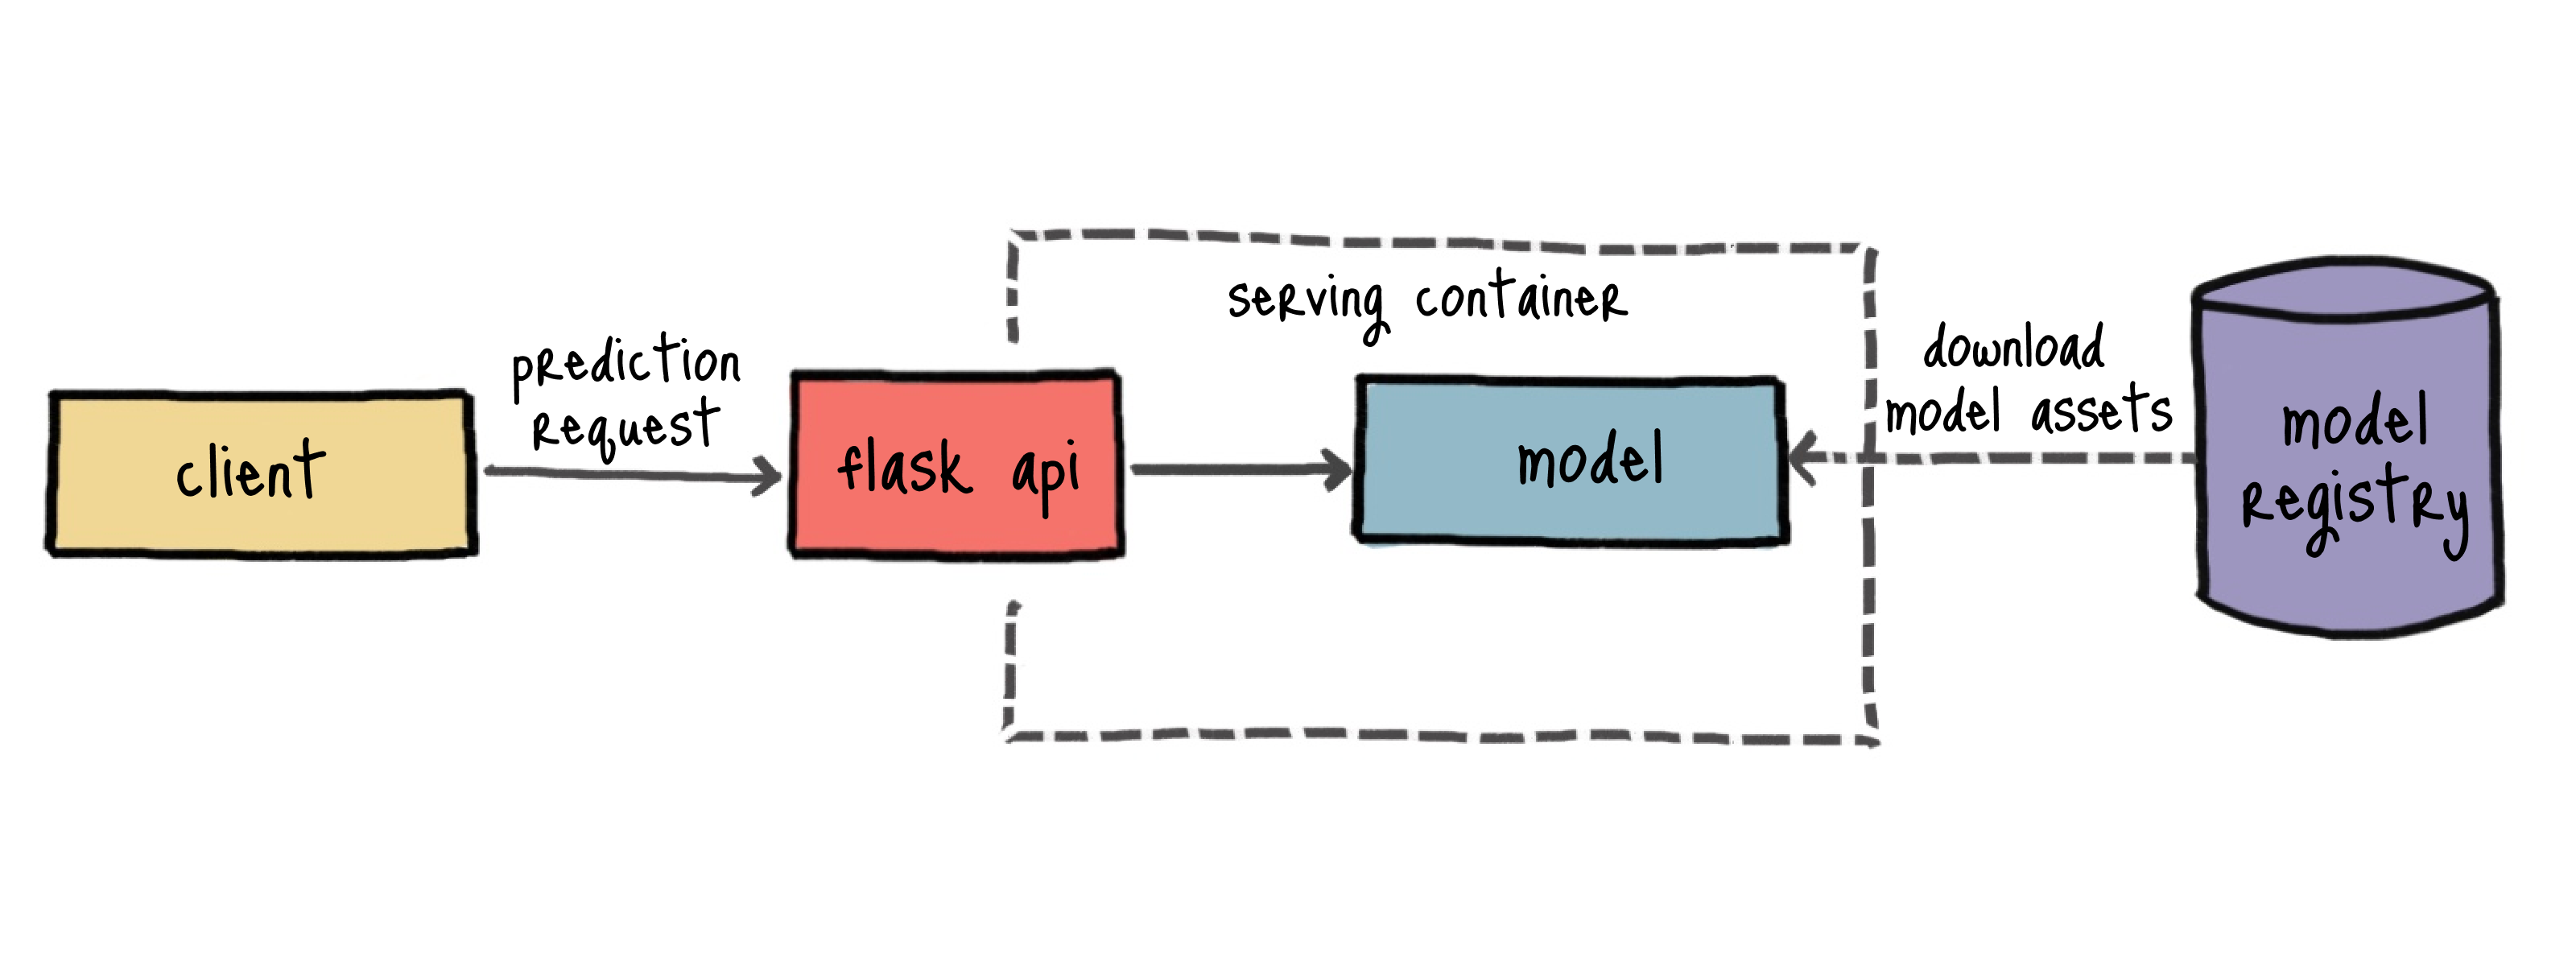

### Step 1 - Retrieving List of Approved Models
We want to serve the latest approved model from the Model Registry. We can use the boto3 API to get this model:

In [ ]:
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=BASIC_MODEL_PACKAGE_GROUP,
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    MaxResults=1,
)

package = (
    response["ModelPackageSummaryList"][0]
    if response["ModelPackageSummaryList"]
    else None
)

package

### Step 2 - Downloading the Model
Let's now download the model assets from the location specified in the Model Registry to your local environment.

We will store this model in a folder called serving:

In [ ]:
(CODE_FOLDER / "serving").mkdir(parents=True, exist_ok=True)

In [ ]:
from sagemaker.s3 import S3Downloader

if package:
    response = sagemaker_client.describe_model_package(
        ModelPackageName=package["ModelPackageArn"],
    )

    model_data = response["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]
    S3Downloader.download(model_data, (CODE_FOLDER / "serving").as_posix())

### Step 3 - Creating the Serving Script
Let's now write a simple Flask script to serve the model.

When this application receives the first request, it will unpack and load the model into memory. From there, it will use the model to make predictions on the incoming requests.

In [ ]:
%%writefile {CODE_FOLDER}/serving/app.py
# | filename: app.py
# | code-line-numbers: true

import tarfile
import tempfile
import numpy as np

from flask import Flask, request, jsonify
from pathlib import Path
from tensorflow import keras


MODEL_PATH = Path(__file__).parent


class Model:
    model = None

    def load(self):
        """
        Extracts the model package and loads the model in memory
        if it hasn't been loaded yet.
        """
        # We want to load the model only if it is not loaded yet.
        if not Model.model:
            # Before we load the model, we need to extract it in
            # a temporal directory.

            with tempfile.TemporaryDirectory() as directory:
                with tarfile.open(MODEL_PATH / "model.tar.gz") as tar:
                    tar.extractall(path=directory)

                Model.model = keras.models.load_model(Path(directory) / "001")

    def predict(self, data):
        """
        Generates predictions for the supplied data.
        """
        self.load()
        return Model.model.predict(data)


app = Flask(__name__)
model = Model()


@app.route("/predict/", methods=["POST"])
def predict():
    data = request.data.decode("utf-8")

    data = np.array(data.split(",")).astype(np.float32)
    data = np.expand_dims(data, axis=0)

    predictions = model.predict(data=[data])

    prediction = int(np.argmax(predictions[0], axis=-1))
    confidence = float(predictions[0][prediction])

    return jsonify({"prediction": prediction, "confidence": confidence})

### Step 4 - Running the Flask Application
We can now run the Flask application to serve the model from a terminal using the following command:

$ flask --app program/code/serving/app.py --debug run --host=0.0.0.0 --port=4242
After the server is running, you can send a POST request to the server to get a prediction. Here is an example using the curl command:

$ curl --location --request POST 'http://localhost:4242/predict' \
    --header 'Content-Type: text/plain' \
    --data-raw '0.6569590202313976, -1.0813829646495108, 1.2097102831892812, 0.9226343641317372, 1.0, 0.0, 0.0'

## Session 11 - Deploying the Model
This session deploys the model from the Model Registry to an endpoint. We'll do it manually, using the SageMaker SDK. Check Deploy to a SageMaker Endpoint for more information about deploying a model to an endpoint.

Deploy to a SageMaker Endpoint :
https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#deploy-to-a-sagemaker-endpoint

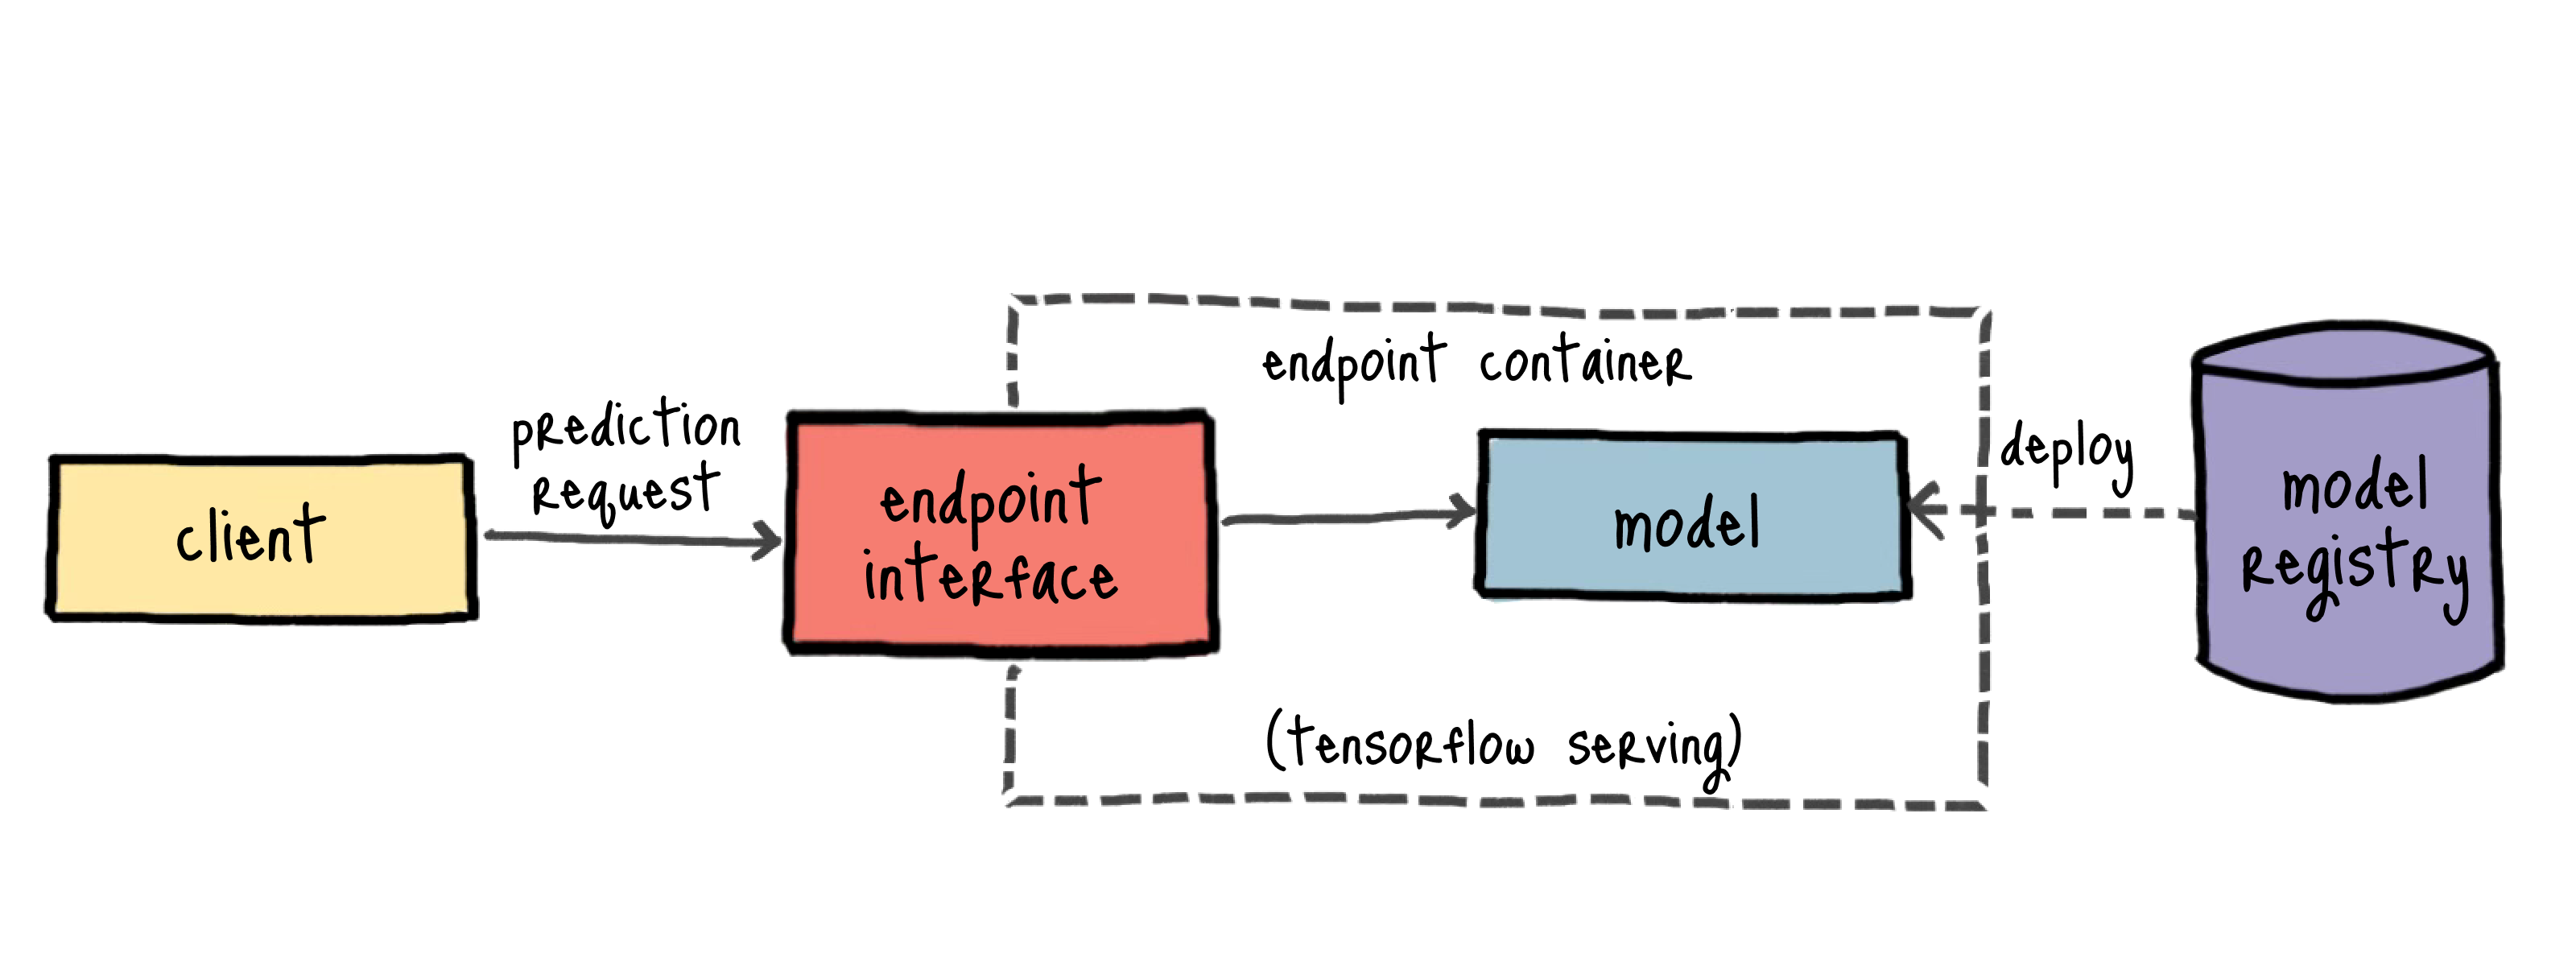

### Step 1 - Configuring the Endpoint Name
Let's start by defining the name of the endpoint where we'll deploy the model:

In [ ]:
from sagemaker.predictor import Predictor

ENDPOINT = "penguins-endpoint"

### Step 2 - Creating a Model Package
To deploy a model using the SageMaker's Python SDK, we need to create a Model Package using the ARN of the model from the Model Registry. Remember we got the ARN of the latest approved model in the previous section.

In [ ]:
from sagemaker import ModelPackage

if package:
    model_package = ModelPackage(
        model_package_arn=package["ModelPackageArn"],
        sagemaker_session=sagemaker_session,
        role=role,
    )

    print(package["ModelPackageArn"])

### Step 3 - Deploying the Model
Let's now deploy the model to an endpoint.

In [ ]:
%%script false --no-raise-error
# | eval: false

model_package.deploy(
    endpoint_name=ENDPOINT,
    initial_instance_count=1,
    instance_type=config["instance_type"],
)

### Step 4 - Testing the Endpoint
After deploying the model, we can test the endpoint to make sure it works.

Each line of the payload we'll send to the endpoint contains the information of a penguin. Notice the model expects data that's already transformed. We can't provide the original data from our dataset because the model we registered will not work with it.

The endpoint will return the predictions for each of these lines.

In [ ]:
payload = """
0.6569590202313976,-1.0813829646495108,1.2097102831892812,0.9226343641317372,1.0,0.0,0.0
-0.7751048801481084,0.8822689351285553,-1.2168066120762704,0.9226343641317372,0.0,1.0,0.0
-0.837387834894918,0.3386660813829646,-0.26237731892812,-1.92351941317372,0.0,0.0,1.0
"""

Let's send the payload to the endpoint and print its response:

In [ ]:
predictor = Predictor(endpoint_name=ENDPOINT)

try:
    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))

    print(json.dumps(response, indent=2))
    print(f"\nSpecies: {np.argmax(response['predictions'], axis=1)}")
except Exception as e:
    print(e)

## Session 12 - Deploying From the Pipeline
This session extends the SageMaker Pipeline with a step to automatically deploy the model to an endpoint.

We'll use a Lambda Step to create an endpoint and deploy the model.

Here's a high-level overview of the Deploy Step:


Lambda step : https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-lambda



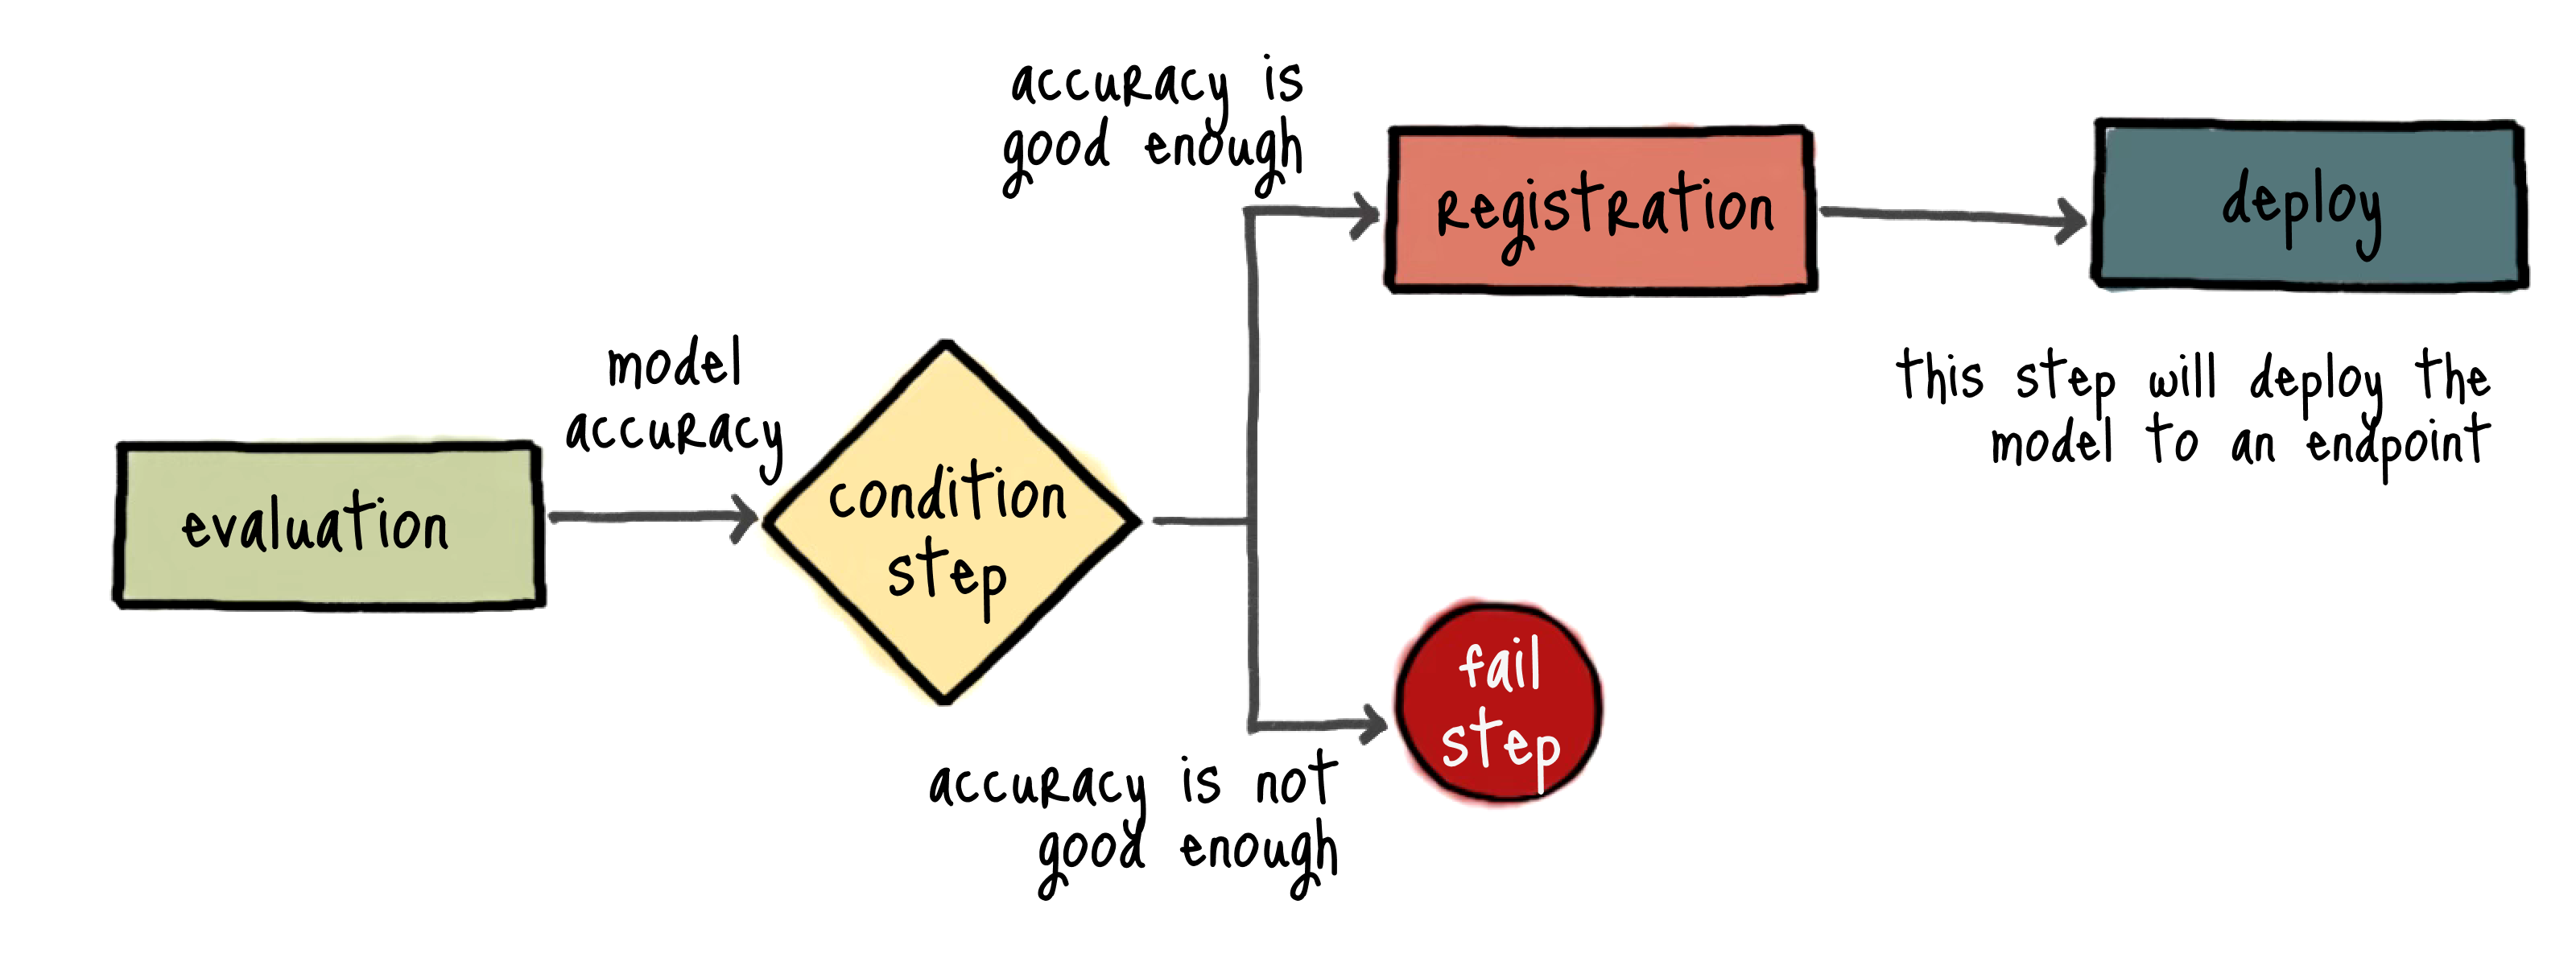

### Step 1 - Configuring Data Capture Settings
We want to enable Data Capture as part of the endpoint configuration. With Data Capture we can record the inputs and outputs of the endpoint to use them later for monitoring the model. We need to configuration settings to enable Data Capture:

DATA_CAPTURE_PERCENTAGE: Represents the percentage of traffic that we want to capture.
DATA_CAPTURE_DESTINATION: Specifies the S3 location where we want to store the captured data.

Data Capture : https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html

In [ ]:
DATA_CAPTURE_PERCENTAGE = 100
DATA_CAPTURE_DESTINATION = f"{S3_LOCATION}/monitoring/data-capture"

### Step 2 - Setting up the Lambda Function
Let's start by writing a Lambda function that takes the model information and deploys it to an endpoint.

There are three components that make up a SageMaker endpoint:

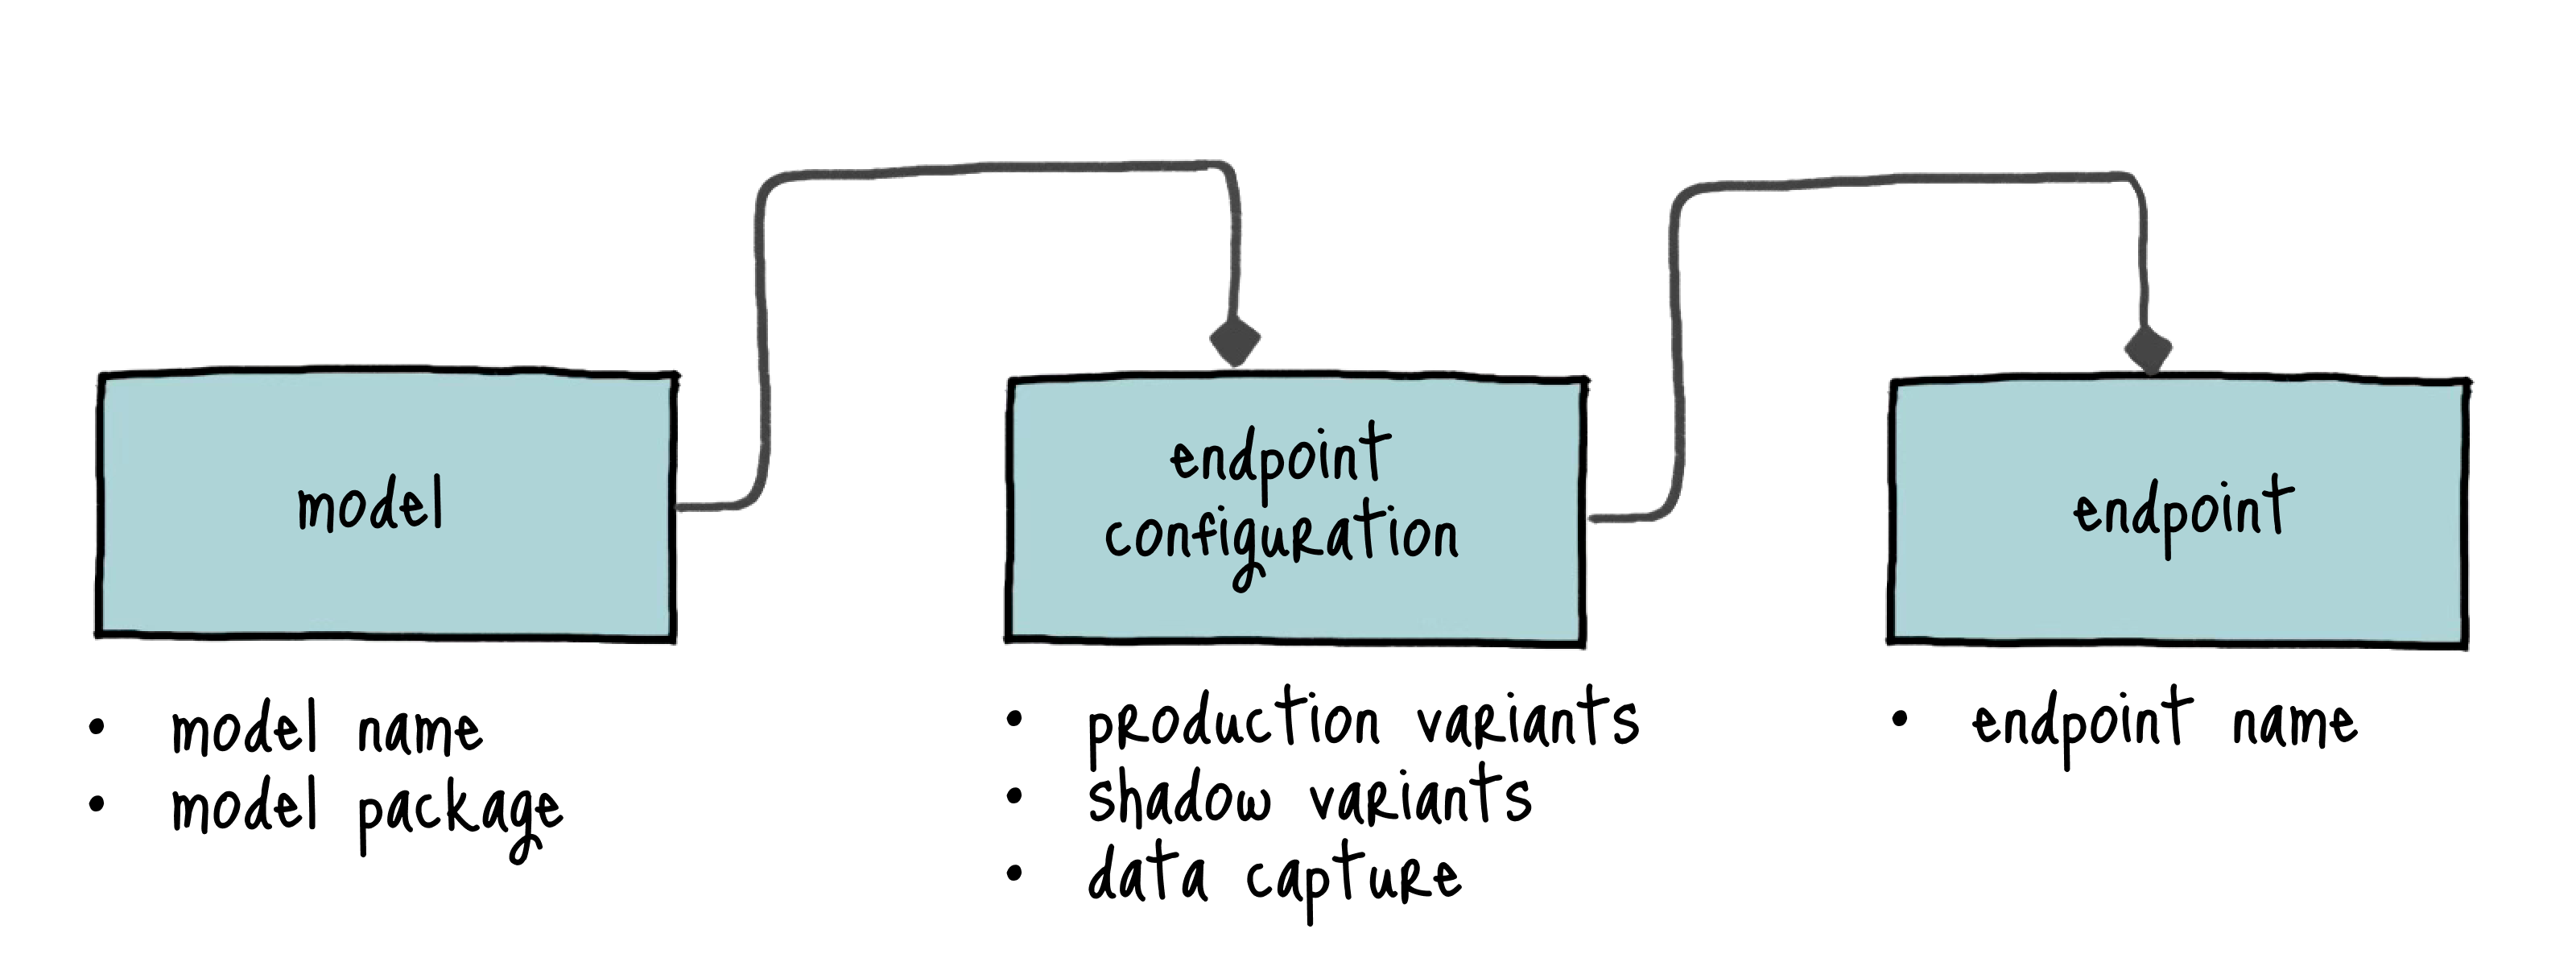

We'll store the code of the function in a folder called lambda:

In [ ]:
(CODE_FOLDER / "lambda").mkdir(parents=True, exist_ok=True)

In [ ]:
%%writefile {CODE_FOLDER}/lambda/lambda.py
# | filename: lambda.py
# | code-line-numbers: true

import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")


def lambda_handler(event, context):
    # If we are calling this function from EventBridge,
    # we need to extract the model package ARN and the
    # approval status from the event details. If we are
    # calling this function from the pipeline, we can
    # assume the model is approved and we can get the
    # model package ARN as a direct parameter.
    if "detail" in event:
        model_package_arn = event["detail"]["ModelPackageArn"]
        approval_status = event["detail"]["ModelApprovalStatus"]
    else:
        model_package_arn = event["model_package_arn"]
        approval_status = "Approved"

    print(f"Model: {model_package_arn}")
    print(f"Approval status: {approval_status}")

    if approval_status != "Approved":
        response = {
            "message": "Skipping deployment.",
            "approval_status": approval_status,
        }

        print(response)
        return {"statusCode": 200, "body": json.dumps(response)}

    endpoint_name = os.environ["ENDPOINT"]
    data_capture_percentage = int(os.environ["DATA_CAPTURE_PERCENTAGE"])
    data_capture_destination = os.environ["DATA_CAPTURE_DESTINATION"]
    role = os.environ["ROLE"]

    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"{endpoint_name}-model-{timestamp}"
    endpoint_config_name = f"{endpoint_name}-config-{timestamp}"

    sagemaker.create_model(
        ModelName=model_name,
        ExecutionRoleArn=role,
        Containers=[{"ModelPackageName": model_package_arn}],
    )

    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "ModelName": model_name,
                "InstanceType": "ml.m5.xlarge",
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "VariantName": "AllTraffic",
            }
        ],
        # We can enable Data Capture to record the inputs and outputs
        # of the endpoint to use them later for monitoring the model.
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": data_capture_percentage,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {"CaptureMode": "Input"},
                {"CaptureMode": "Output"},
            ],
            "CaptureContentTypeHeader": {
                "CsvContentTypes": ["text/csv", "application/octect-stream"],
                "JsonContentTypes": ["application/json", "application/octect-stream"],
            },
        },
    )

    response = sagemaker.list_endpoints(NameContains=endpoint_name, MaxResults=1)

    if len(response["Endpoints"]) == 0:
        # If the endpoint doesn't exist, let's create it.
        sagemaker.create_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName=endpoint_config_name,
        )
    else:
        # If the endpoint already exists, let's update it with the
        # new configuration.
        sagemaker.update_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName=endpoint_config_name,
        )

    return {"statusCode": 200, "body": json.dumps("Endpoint deployed successfully")}

### Step 3 - Setting up Lambda Permissions
We need to ensure our Lambda function has permission to interact with SageMaker, so let's create a new role with the appropriate permissions.

In [ ]:
lambda_role_name = "lambda-deployment-role"
lambda_role_arn = None

try:
    response = iam_client.create_role(
        RoleName=lambda_role_name,
        AssumeRolePolicyDocument=json.dumps(
            {
                "Version": "2012-10-17",
                "Statement": [
                    {
                        "Effect": "Allow",
                        "Principal": {
                            "Service": ["lambda.amazonaws.com", "events.amazonaws.com"],
                        },
                        "Acti,on": "sts:AssumeRole",
                    },
                ],
            },
        ),
        Description="Lambda Endpoint Deployment",
    )

    lambda_role_arn = response["Role"]["Arn"]

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        RoleName=lambda_role_name,
    )

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
        RoleName=lambda_role_name,
    )

    print(f'Role "{lambda_role_name}" created with ARN "{lambda_role_arn}".')
except iam_client.exceptions.EntityAlreadyExistsException:
    response = iam_client.get_role(RoleName=lambda_role_name)
    lambda_role_arn = response["Role"]["Arn"]
    print(f'Role "{lambda_role_name}" already exists with ARN "{lambda_role_arn}".')